# Electricity price prediction

A fundamental element in data science is that of forecasting. Particularly in the world of energy, as it is very complex and has many variables. In order to be able to make more precise analyses, machine learning and deep learning can give us an impactful hand, thanks to their ability to grasp relationships between variables. In this notebook, we will show a quick exploratory analysis and finally an application of algorithms.
In particular, two algorithms of ML (Machine Learning) and Deep Learning (DL) have been chosen, but the really impactful part is the exploratory analysis (EDA). Indeed, as will be seen, even simpler models (such as KNN) are capable of yielding considerable results.

Let us show, step by step, how to reach a very good result in forecasting.

In [89]:
import pandas as pd 
import xgboost as xgb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats
from sklearn.decomposition import PCA
import xgboost
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.tsa.arima.model import ARIMA
from autots import AutoTS
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector

import warnings
warnings.filterwarnings("ignore")

In [90]:
import kagglehub #We will download our data using from Kaggle, using the famous notebook: KaggleHub.

# Download latest version
path = kagglehub.dataset_download("nicholasjhana/energy-consumption-generation-prices-and-weather")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\admin\.cache\kagglehub\datasets\nicholasjhana\energy-consumption-generation-prices-and-weather\versions\1


Let's see energy dataset, with data obtained by ENTSOE(https://transparency.entsoe.eu/dashboard/show), regarding consumption and generation data, and Spanish TSO Red Electric España (https://www.esios.ree.es/en/market-and-prices) , with regard to settlement prices.

In [91]:
energy_dataset=pd.read_csv(f"{path}\energy_dataset.csv") 
energy_dataset.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [92]:
energy_dataset.shape

(35064, 29)

Let us see heading of weather data, obtained the weather provider Open Meteo (https://openweathermap.org/api).

In [93]:
weather_features=pd.read_csv(f"{path}\weather_features.csv")

weather_features.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [94]:
weather_features.shape

(178396, 17)

# Energy Dataset

We will clean energy dataset analysing box plots and deleting outliers. We will then delete outliers by interpolation. Let's start! 

In [95]:
energy_dataset.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [96]:
energy_dataset.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

We will remove uneuseful columns and forecast columns.

In [97]:
energy_dataset[['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead']]

generation fossil coal-derived gas  generation fossil oil shale  \
0                                     0.0                          0.0   
1                                     0.0                          0.0   
2                                     0.0                          0.0   
3                                     0.0                          0.0   
4                                     0.0                          0.0   
...                                   ...                          ...   
35059                                 0.0                          0.0   
35060                                 0.0                          0.0   
35061                                 0.0                          0.0   
35062                                 0.0                          0.0   
35063                                 0.0                          0.0   

       generation fossil peat  generation geothermal  \
0                         0.0                    0.0   
1                         0.0                    0.0   
2                         0.0                    0.0   
3                         0.0                    0.0   
4                         0.0                    0.0   
...                       ...                    ...   
35059                     0.0                    0.0   
35060                     0.0                    0.0   
35061                     0.0                    0.0   
35062                     0.0                    0.0   
35063                     0.0                    0.0   

       generation hydro pumped storage aggregated  generation marine  \
0                                             NaN                0.0   
1                                             NaN                0.0   
2                                             NaN                0.0   
3                                             NaN                0.0   
4                                             NaN                0.0   
...                                           ...                ...   
35059                                         NaN                0.0   
35060                                         NaN                0.0   
35061                                         NaN                0.0   
35062                                         NaN                0.0   
35063                                         NaN                0.0   

       generation wind offshore  forecast wind offshore eday ahead  \
0                           0.0                                NaN   
1                           0.0                                NaN   
2                           0.0                                NaN   
3                           0.0                                NaN   
4                           0.0                                NaN   
...                         ...                                ...   
35059                       0.0                                NaN   
35060                       0.0                                NaN   
35061                       0.0                                NaN   
35062                       0.0                                NaN   
35063                       0.0                                NaN   

       total load forecast  forecast solar day ahead  \
0                  26118.0                      17.0   
1                  24934.0                      16.0   
2                  23515.0                       8.0   
3                  22642.0                       2.0   
4                  21785.0                       9.0   
...                    ...                       ...   
35059              30619.0                      96.0   
35060              29932.0                      51.0   
35061              27903.0                      36.0   
35062              25450.0                      29.0   
35063              24424.0                      26.0   

       forecast wind onshore day ahead  
0                        

In [98]:
energy_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

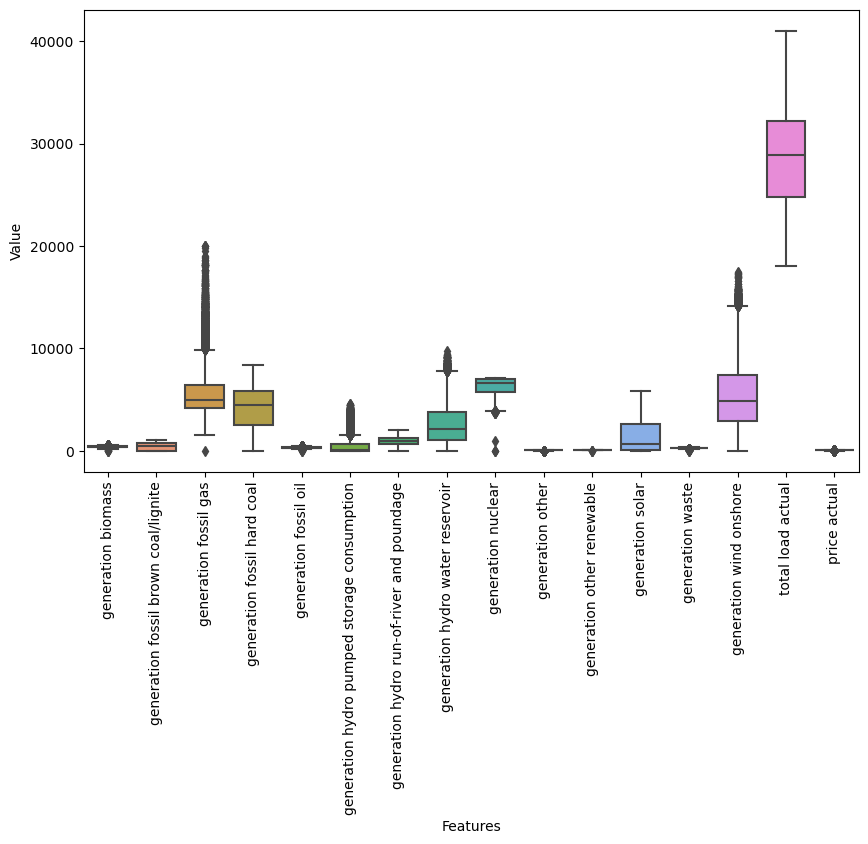

In [99]:
try:
    energy_dataset = energy_dataset.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead','price day ahead'], 
                           axis=1)
except:
    pass

#Select numerical coloumns
numeric_columns = energy_dataset.select_dtypes(include='number').columns

# let us create a long dataframe
df_long = energy_dataset.melt(value_vars=numeric_columns, var_name='Features', value_name='Value')
# Let us show boxplot
fig = plt.figure(figsize=(10,6))

sns.boxplot(df_long, x='Features', y='Value')

plt.xticks(rotation=90)

#Box Plot visualization
fig.show()


Here we will remove outliers filtering with a treshold. Idea, as you can observe, is very simple.

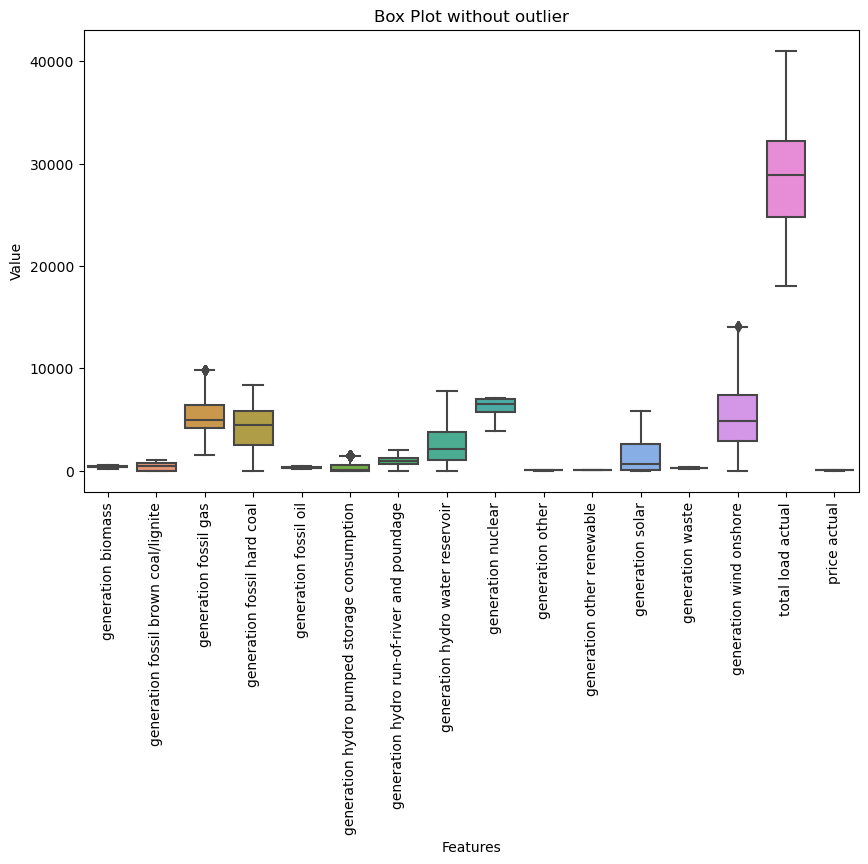

In [100]:
num_energy_dataset=energy_dataset[numeric_columns]
Q1 = num_energy_dataset.quantile(0.25)
Q3 = num_energy_dataset.quantile(0.75)
IQR = Q3 - Q1 # filtering outliers
df_no_outliers = num_energy_dataset.mask((num_energy_dataset < (Q1 - 1.5 * IQR)) | (num_energy_dataset > (Q3 + 1.5 * IQR)),np.nan)

df_no_outliers=df_no_outliers.interpolate(method='linear')

df_no_outliers.head()


df_long = df_no_outliers.melt(value_vars=numeric_columns, var_name='Features', value_name='Value')

fig=plt.figure(figsize=(10,6))

sns.boxplot(df_long, x='Features', y='Value')

plt.title('Box Plot without outlier')

plt.xticks(rotation=90)

#Box Plot visualization
fig.show()


In [101]:
energy_dataset[numeric_columns]=df_no_outliers #let's remove outliers from energy_dataset

energy_dataset['time']=pd.to_datetime(energy_dataset['time'])

energy_dataset=energy_dataset.sort_values(by='time')

energy_dataset.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   
2                                 323.0                 4857.0   
3                                 254.0                 4314.0   
4                                 187.0                 4130.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                    NaN   
1                       4755.0                    NaN   
2                       4581.0                    NaN   
3                       4131.0                    NaN   
4                       3840.0                    NaN   

   generation hydro pumped storage consumption  \
0                                        863.0   
1                                        920.0   
2                                       1164.0   
3                                       1503.0   
4                                       1463.0   

   generation hydro run-of-river and poundage  \
0                                      1051.0   
1                                      1009.0   
2                                       973.0   
3                                       949.0   
4                                       953.0   

   generation hydro water reservoir  generation nuclear  generation other  \
0                            1899.0              7096.0              43.0   
1                            1658.0              7096.0              43.0   
2                            1371.0              7099.0              43.0   
3                             779.0              7098.0              43.0   
4                             720.0              7097.0              43.0   

   generation other renewable  generation solar  generation waste  \
0                        73.0              49.0             196.0   
1                        71.0              50.0             195.0   
2                        73.0              50.0             196.0   
3                        75.0              50.0             191.0   
4                        74.0              42.0             189.0   

   generation wind onshore  total load actual  price actual  
0                   6378.0            25385.0         65.41  
1                   5890.0            24382.0         64.92  
2                   5461.0            22734.0         64.48  
3                   5238.0            21286.0         59.32  
4                   4935.0            20264.0         56.04

In [102]:
energy_dataset=energy_dataset.interpolate(method='linear')
energy_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35064 non-null  float64
 2   generation fossil brown coal/lignite         35064 non-null  float64
 3   generation fossil gas                        35064 non-null  float64
 4   generation fossil hard coal                  35064 non-null  float64
 5   generation fossil oil                        35055 non-null  float64
 6   generation hydro pumped storage consumption  35064 non-null  float64
 7   generation hydro run-of-river and poundage   35064 non-null  float64
 8   generation hydro water reservoir             35064 non-null  float64
 9   generation nuclear                           35064 non-null  float64
 10

# Weather Dataset

First thing to do in weather dataset is to insert cities as columns in dataframe. Indeed in this dataset there are 5 most big cities in Spain: Madrid, Barcelona, Bilbao, Seville and Valencia.


In [103]:
weather_features.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [104]:
weather_features['city_name'].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

In [105]:
weather_features.describe().round(1)

temp  temp_min  temp_max   pressure  humidity  wind_speed  \
count  178396.0  178396.0  178396.0   178396.0  178396.0    178396.0   
mean      289.6     288.3     291.1     1069.3      68.4         2.5   
std         8.0       8.0       8.6     5969.6      21.9         2.1   
min       262.2     262.2     262.2        0.0       0.0         0.0   
25%       283.7     282.5     284.6     1013.0      53.0         1.0   
50%       289.2     288.2     290.2     1018.0      72.0         2.0   
75%       295.2     293.7     297.2     1022.0      87.0         4.0   
max       315.6     315.2     321.2  1008371.0     100.0       133.0   

       wind_deg   rain_1h   rain_3h   snow_3h  clouds_all  weather_id  
count  178396.0  178396.0  178396.0  178396.0    178396.0    178396.0  
mean      166.6       0.1       0.0       0.0        25.1       759.8  
std       116.6       0.4       0.0       0.2        30.8       108.7  
min         0.0       0.0       0.0       0.0         0.0       200.0  
25%        55.0       0.0       0.0       0.0         0.0       800.0  
50%       177.0       0.0       0.0       0.0        20.0       800.0  
75%       270.0       0.0       0.0       0.0        40.0       801.0  
max       360.0      12.0       2.3      21.5       100.0       804.0

There are some things to note:
1) pressure has at least an outlier: indeed 1008371	is too big. 
2) there is at least an outlier in wind_speed: 133 m/s is too big value.

Let's remove then outliers, as we did in Energy Dataset.

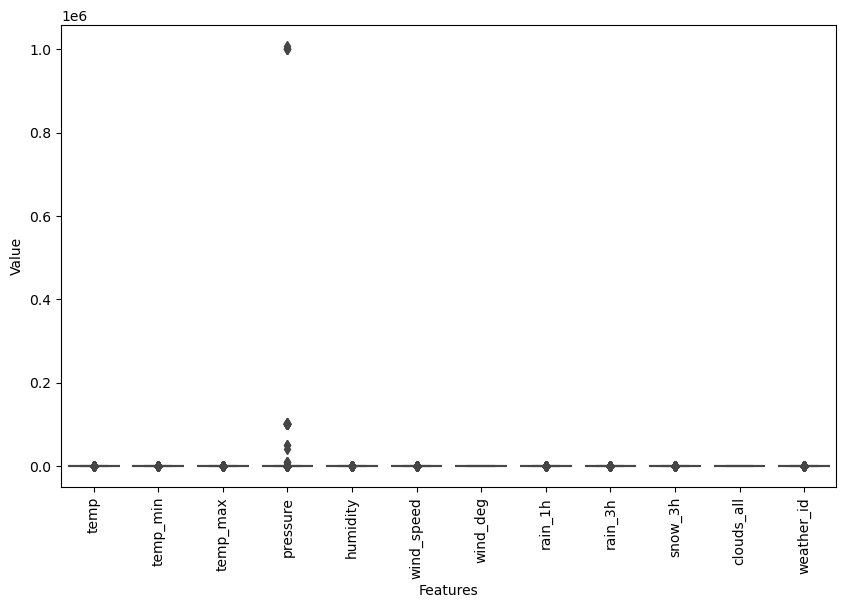

In [106]:
#Select numeric features
numeric_columns = weather_features.select_dtypes(include='number').columns

#let's create a long dataframe
df_long = weather_features.melt(value_vars=numeric_columns, var_name='Features', value_name='Value')
#Box Plot creation
plt.figure(figsize=(10, 6))
fig = sns.boxplot(df_long, x='Features', y='Value')

plt.xticks(rotation=90)

#Box Plot visualization
plt.show()



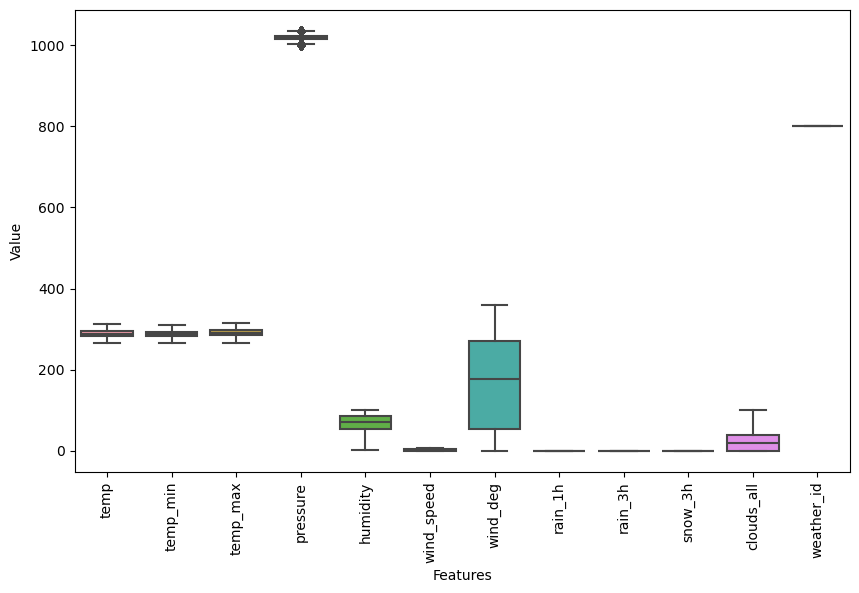

In [107]:
Q1 = weather_features[numeric_columns].quantile(0.25)
Q3 =  weather_features[numeric_columns].quantile(0.75)
IQR = Q3 - Q1 # Outlier filtering
df_no_outliers = weather_features[numeric_columns].mask((weather_features[numeric_columns] < (Q1 - 1.5 * IQR)) | (weather_features[numeric_columns] > (Q3 + 1.5 * IQR)),np.nan)

df_no_outliers=df_no_outliers.interpolate(method='linear')


df_long = df_no_outliers.melt(value_vars=numeric_columns, var_name='Features', value_name='Value')

fig=plt.figure(figsize=(10, 6))
sns.boxplot(df_long,x='Features',y='Value')
plt.xticks(rotation=90)
weather_features[numeric_columns]=df_no_outliers
plt.show()
#we will remove, being null, 'rain_1h','rain_3h' and 'snow_3h'.
try:
    weather_features=weather_features.drop(['rain_1h','rain_3h','snow_3h'],axis=1)
except:
    pass


In [108]:
weather_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  float64
 6   humidity             178396 non-null  float64
 7   wind_speed           178396 non-null  float64
 8   wind_deg             178396 non-null  int64  
 9   clouds_all           178396 non-null  int64  
 10  weather_id           178396 non-null  float64
 11  weather_main         178396 non-null  object 
 12  weather_description  178396 non-null  object 
 13  weather_icon         178396 non-null  object 
dtypes: float64(7), int64(2), object(5)
memory usage: 19.1+ MB


In [109]:
weather_features = weather_features.map(lambda x: float(x) if isinstance(x, int) else x)
weather_features.info()

weather_features.columns



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  float64
 6   humidity             178396 non-null  float64
 7   wind_speed           178396 non-null  float64
 8   wind_deg             178396 non-null  float64
 9   clouds_all           178396 non-null  float64
 10  weather_id           178396 non-null  float64
 11  weather_main         178396 non-null  object 
 12  weather_description  178396 non-null  object 
 13  weather_icon         178396 non-null  object 
dtypes: float64(9), object(5)
memory usage: 19.1+ MB


Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id',
       'weather_main', 'weather_description', 'weather_icon'],
      dtype='object')

In [110]:
weather_features_pivot=weather_features.pivot_table(columns='city_name',index='dt_iso',values=['temp', 'temp_min', 'temp_max', 'pressure',
'humidity', 'wind_speed', 'wind_deg','clouds_all', 'weather_id']).reset_index()

#let's move city names in coloumns

In [111]:
weather_features_pivot.columns = [f"{city}_{data}" for city, data in weather_features_pivot.columns]

In [112]:
weather_features_pivot.head()

weather_features_pivot['dt_iso_']=pd.to_datetime(weather_features_pivot['dt_iso_'],utc=True)
energy_dataset['time']=pd.to_datetime(energy_dataset['time'],utc=True)

In [113]:
df=energy_dataset.merge(weather_features_pivot, left_on=['time'],right_on=['dt_iso_'])

df=df.drop(['dt_iso_'],axis=1)

df=df.sort_values(by='time')


In [114]:
df.replace(np.nan,0,inplace=True)

df.head()

time  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   
2 2015-01-01 01:00:00+00:00               448.0   
3 2015-01-01 02:00:00+00:00               438.0   
4 2015-01-01 03:00:00+00:00               428.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   
2                                 323.0                 4857.0   
3                                 254.0                 4314.0   
4                                 187.0                 4130.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                    0.0   
1                       4755.0                    0.0   
2                       4581.0                    0.0   
3                       4131.0                    0.0   
4                       3840.0                    0.0   

   generation hydro pumped storage consumption  \
0                                        863.0   
1                                        920.0   
2                                       1164.0   
3                                       1503.0   
4                                       1463.0   

   generation hydro run-of-river and poundage  \
0                                      1051.0   
1                                      1009.0   
2                                       973.0   
3                                       949.0   
4                                       953.0   

   generation hydro water reservoir  generation nuclear  ...  \
0                            1899.0              7096.0  ...   
1                            1658.0              7096.0  ...   
2                            1371.0              7099.0  ...   
3                             779.0              7098.0  ...   
4                             720.0              7097.0  ...   

   wind_deg_ Barcelona  wind_deg_Bilbao  wind_deg_Madrid  wind_deg_Seville  \
0                 58.0            226.0            309.0              21.0   
1                 58.0            229.0            309.0              21.0   
2                 48.0            224.0            273.0              27.0   
3                 48.0            225.0            273.0              27.0   
4                 48.0            221.0            273.0              27.0   

   wind_deg_Valencia  wind_speed_ Barcelona  wind_speed_Bilbao  \
0               62.0                    7.0                0.0   
1               62.0                    7.0                0.0   
2               23.0                    7.0                1.0   
3               23.0                    7.0                1.0   
4               23.0                    7.0                1.0   

   wind_speed_Madrid  wind_speed_Seville  wind_speed_Valencia  
0                1.0                 1.0                  1.0  
1                1.0                 1.0                  1.0  
2                1.0                 3.0                  0.0  
3                1.0                 3.0                  0.0  
4                1.0                 3.0                  0.0  

[5 rows x 62 columns]

# Target Analysis and Visualization

In [115]:
df['rolling Mean Over 7 days']=df['price actual'].rolling(window=7*24).mean().dropna()

df['rolling Mean Over 24 hours']=df['price actual'].rolling(window=24).mean().dropna()

#df['rolling_std']=df['price actual'].rolling(window=7*24).std()

ADF Statistic: -8.87676097599902
p-value: 1.3514194456139455e-14
Critical Values: {'1%': -3.4305367814665044, '5%': -2.8616225527935106, '10%': -2.566813940257257}
Time Series is stationary


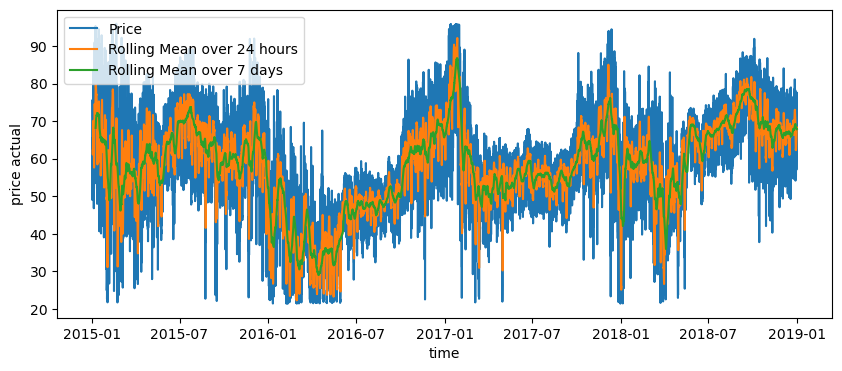

In [116]:
df_long = df[['time','price actual','rolling Mean Over 24 hours','rolling Mean Over 7 days']].melt(id_vars='time',value_vars=['price actual','rolling Mean Over 24 hours','rolling Mean Over 7 days'], var_name='Features', value_name='Value')

fig=plt.figure(figsize=(10,4))
sns.lineplot(df[['time','price actual']],x='time',y='price actual',label='Price')

sns.lineplot(df[['time','rolling Mean Over 24 hours']],x='time',y='rolling Mean Over 24 hours',label='Rolling Mean over 24 hours')

sns.lineplot(df[['time','rolling Mean Over 7 days']],x='time',y='rolling Mean Over 7 days',label='Rolling Mean over 7 days')

plt.legend(loc='best')

plt.xticks()

fig.show()

try:
    df=df.drop(['rolling Mean Over 7 days','rolling Mean Over 24 hours'],axis=1)
except:
    pass

result = adfuller(df['price actual'])

#Is time series stationary, according to Augmented Dickey Fuller?

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])



if result[1] < 0.01:
    print("Time Series is stationary")
else:
    print("Time Series is not stanionary")

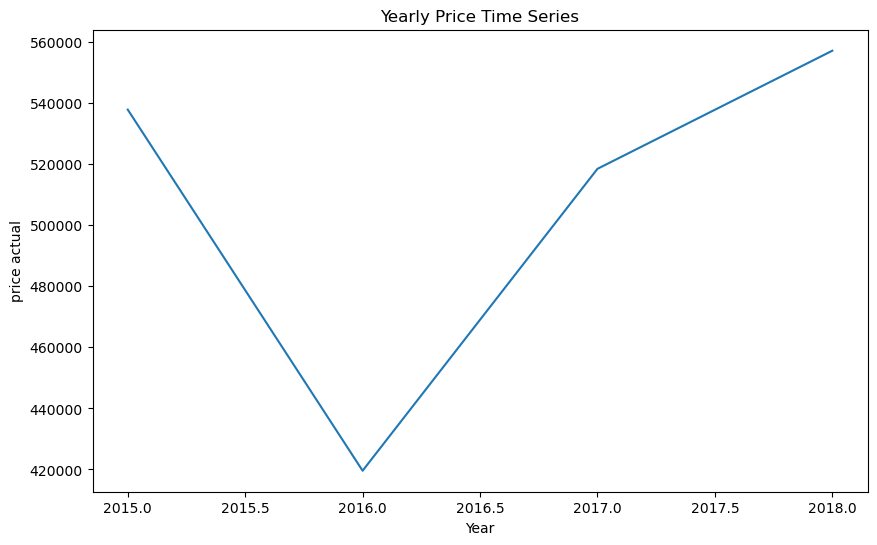

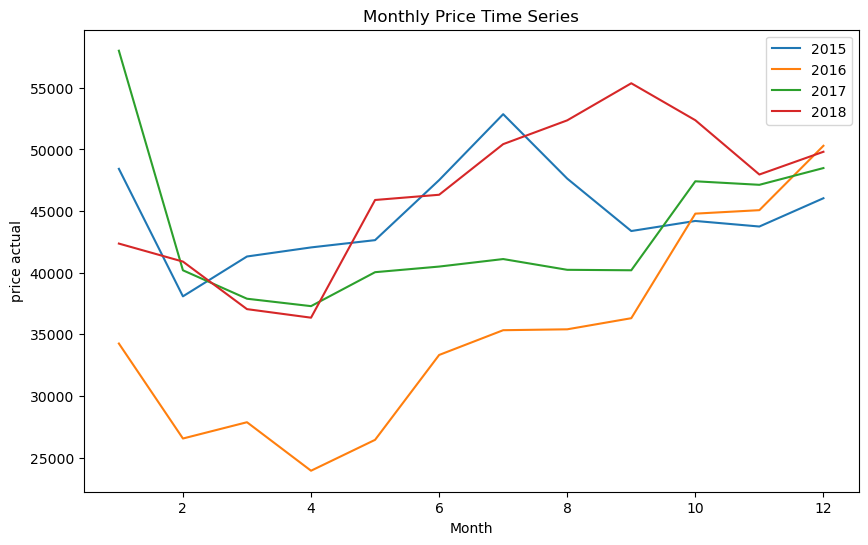

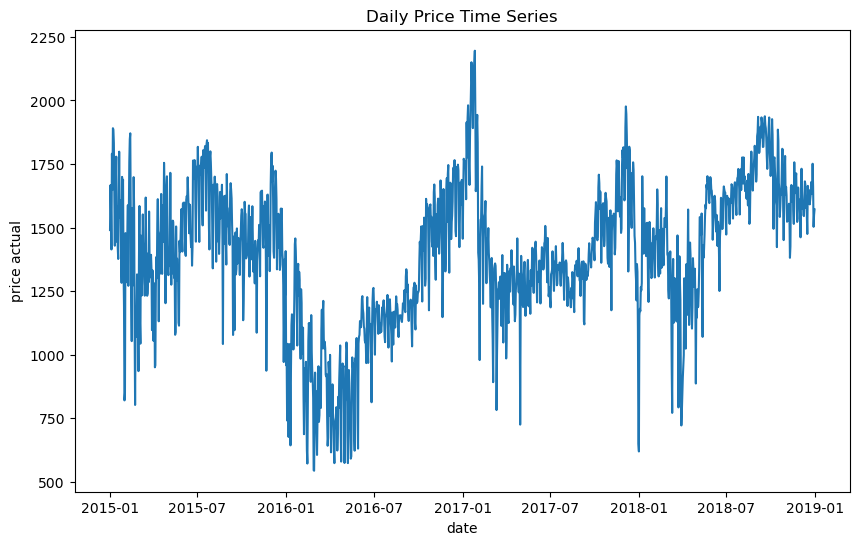

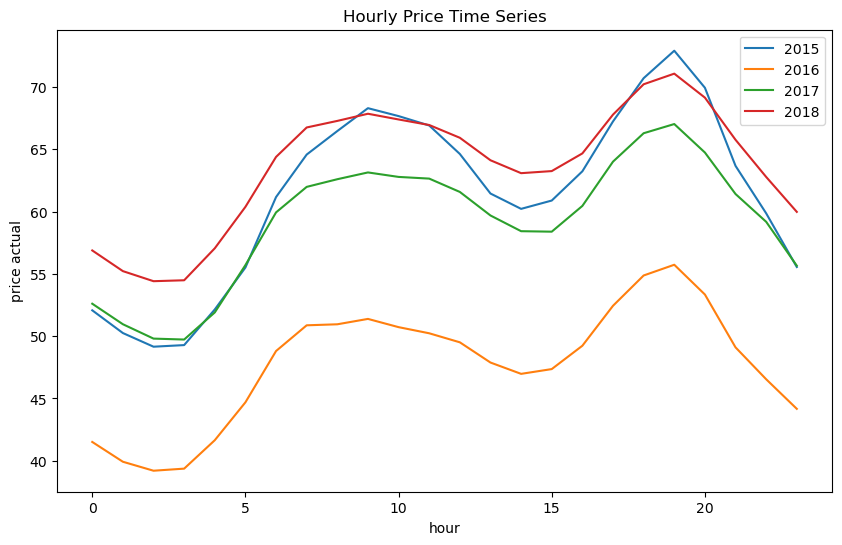

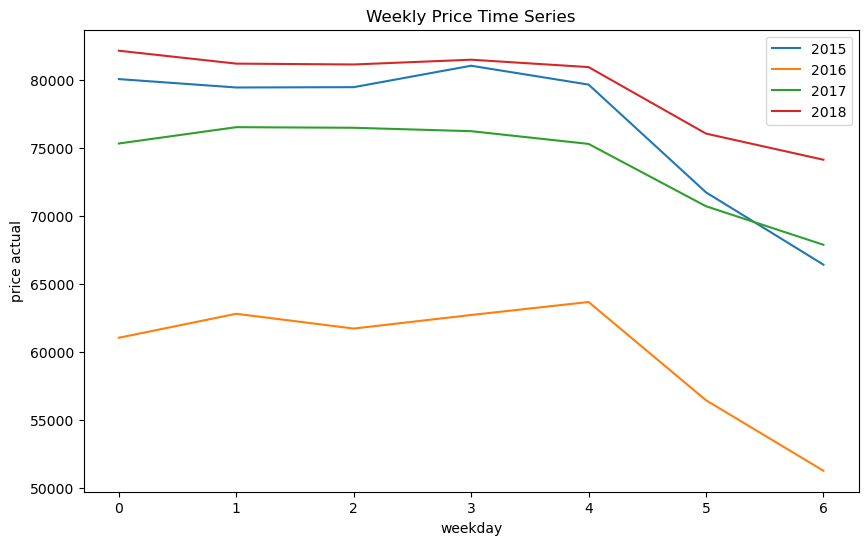

In [117]:
df['Month']=df['time'].dt.month

df['Year']=df['time'].dt.year

df['date']=df['time'].dt.date

df['hour']=df['time'].dt.hour

df['weekday']=df['time'].dt.weekday


df=df.loc[df['Year']>2014]



df_grouped=df.groupby(['Year'])['price actual'].sum().reset_index()

fig=plt.figure(figsize=(10,6))
sns.lineplot(df_grouped,x='Year',y='price actual')

plt.title('Yearly Price Time Series')


fig.show()


df_grouped=df.groupby(['Month','Year'])['price actual'].sum().reset_index()

fig=plt.figure(figsize=(10,6))
for k in range(min(df['Year']),max(df['Year'])+1):
    sns.lineplot(df_grouped.loc[df_grouped['Year']==k],x='Month',y='price actual',label=str(k))

plt.title('Monthly Price Time Series')

plt.legend()

fig.show()



df_grouped=df.groupby(['date'])['price actual'].sum().reset_index()

fig=plt.figure(figsize=(10,6))
sns.lineplot(df_grouped,x='date',y='price actual')
plt.title('Daily Price Time Series')
fig.show()

fig=plt.figure(figsize=(10,6))

df_grouped=df.groupby(['hour','Year'])['price actual'].mean().reset_index()

for k in range(min(df['Year']),max(df['Year'])+1):
    sns.lineplot(df_grouped.loc[df_grouped['Year']==k],x='hour',y='price actual',label=str(k))
    
plt.title('Hourly Price Time Series')
    
fig.show()

df_grouped=df.groupby(['weekday','Year'])['price actual'].sum().reset_index()

fig=plt.figure(figsize=(10,6))


for k in range(min(df['Year']),max(df['Year'])+1):
    sns.lineplot(df_grouped.loc[df_grouped['Year']==k],x='weekday',y='price actual',label=str(k))
    

plt.title('Weekly Price Time Series')

fig.show()




In [118]:
#Being our data in spain, we distinguish hours siesta hour ('2'), business hour (0) and night hour (1).

df['business_hour']=1

df.loc[((df['hour']>=14) & (df['hour']<=16)),'business_hour']=2

df.loc[(((df['hour']>8) & (df['hour']<14)) | ((df['hour']>16) & (df['hour']<21))),'business_hour']=0

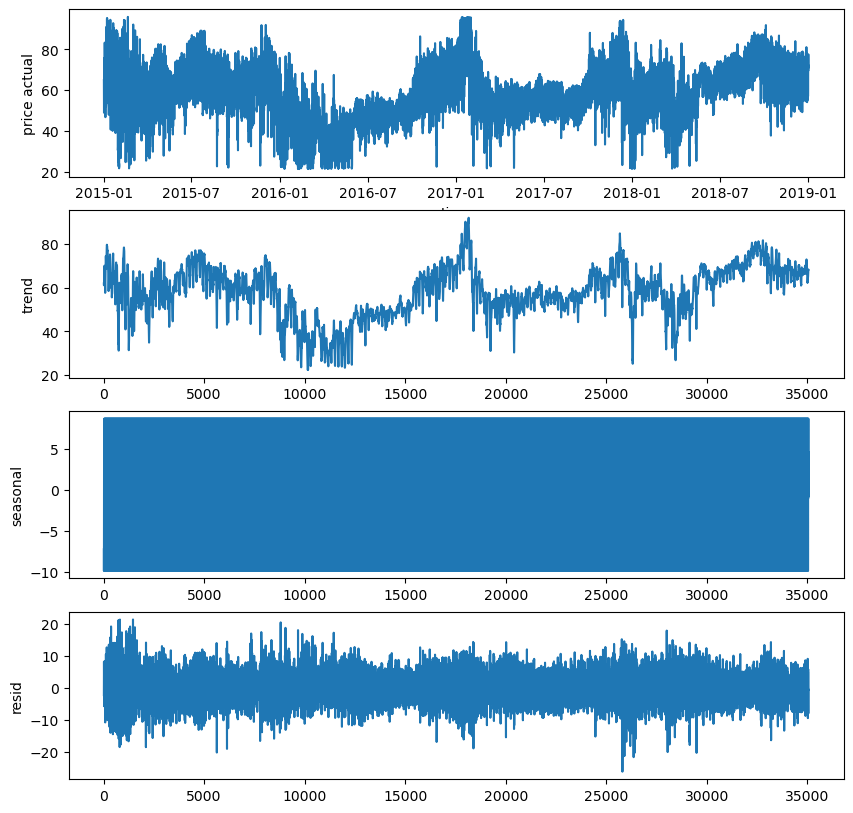

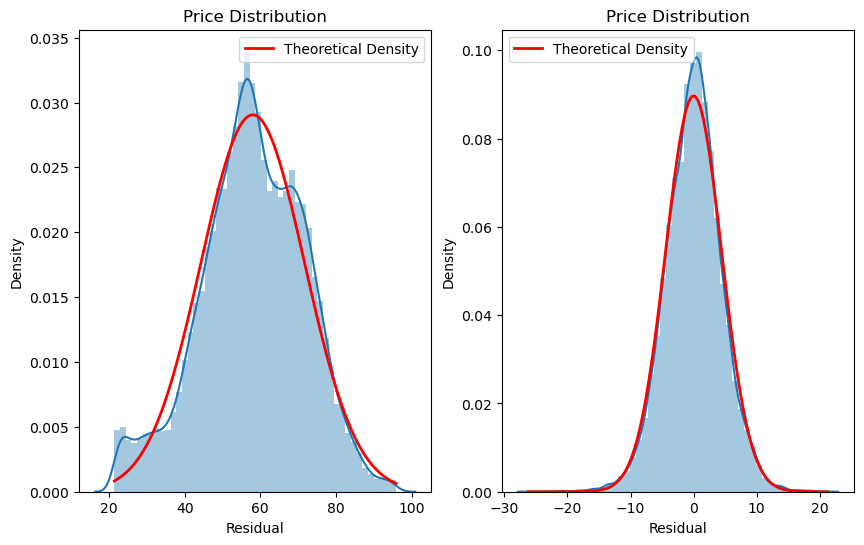

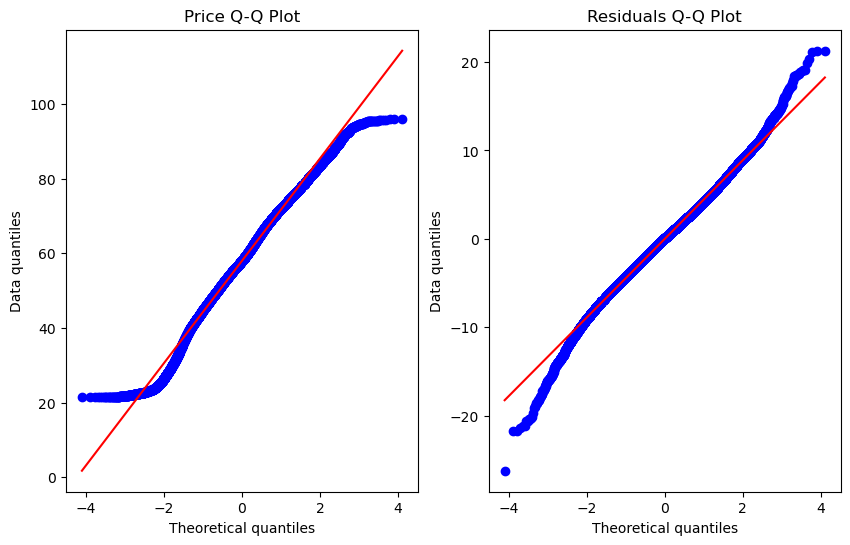

In [119]:
#Time series decomposition
decomposition = seasonal_decompose(df['price actual'], model='additive', period=24)

#Feature exctration
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()

fig=plt.figure(figsize=(10,10))

plt.subplot(4,1,1)

sns.lineplot(df,x='time',y='price actual')

plt.subplot(4,1,2)

sns.lineplot(trend)


plt.subplot(4,1,3)

sns.lineplot(seasonal)


plt.subplot(4,1,4)

sns.lineplot(residual)


fig.show()

x = np.linspace(min(residual), max(residual), 100)
y = stats.norm.pdf(x, loc=residual.mean(), scale=residual.std())


x1 = np.linspace(min(df['price actual']), max(df['price actual']), 100)
y1 = stats.norm.pdf(x1, loc=df['price actual'].mean(), scale=df['price actual'].std())


fig=plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.distplot(df['price actual'])
plt.plot(x1, y1, 'r-', lw=2, label='Theoretical Density')
plt.title('Price Distribution')
plt.xlabel('Residual')
plt.legend()
plt.subplot(1,2,2)
sns.distplot(residual)
plt.plot(x, y, 'r-', lw=2, label='Theoretical Density')
plt.title('Price Distribution')
plt.xlabel('Residual')
plt.legend()
fig.show()

fig=plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
stats.probplot(df['price actual'], dist="norm", plot=plt)
plt.title('Price Q-Q Plot')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Data quantiles')
plt.subplot(1,2,2)
stats.probplot(residual, dist="norm", plot=plt)
plt.title('Residuals Q-Q Plot')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Data quantiles')
plt.show()
fig.show()

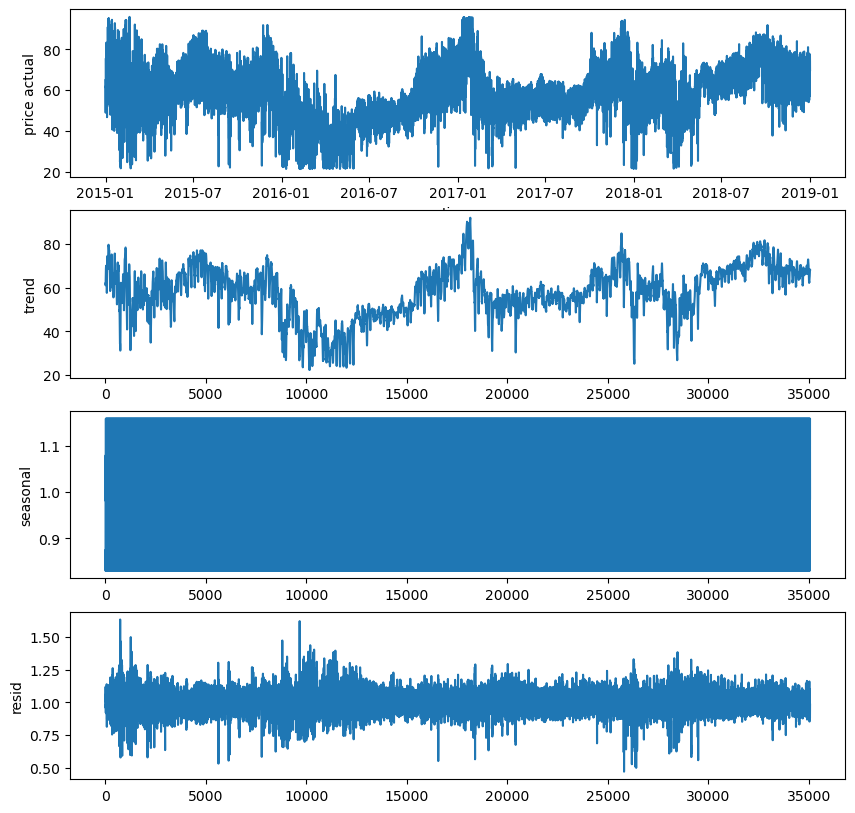

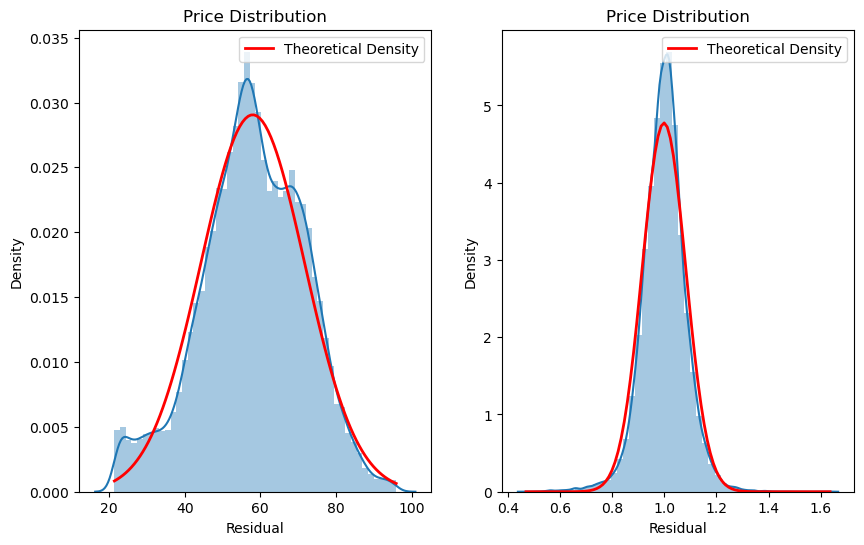

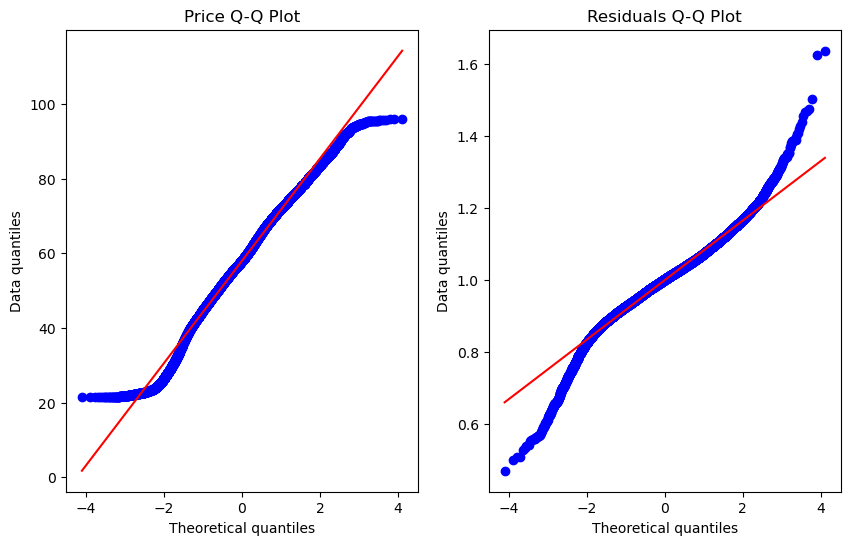

In [120]:
#Time series decomposition
decomposition = seasonal_decompose(df['price actual'], model='multiplicative', period=24)

#Feature exctration
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()

fig=plt.figure(figsize=(10,10))

plt.subplot(4,1,1)

sns.lineplot(df,x='time',y='price actual')

plt.subplot(4,1,2)

sns.lineplot(trend)


plt.subplot(4,1,3)

sns.lineplot(seasonal)


plt.subplot(4,1,4)

sns.lineplot(residual)


fig.show()

x = np.linspace(min(residual), max(residual), 100)
y = stats.norm.pdf(x, loc=residual.mean(), scale=residual.std())


x1 = np.linspace(min(df['price actual']), max(df['price actual']), 100)
y1 = stats.norm.pdf(x1, loc=df['price actual'].mean(), scale=df['price actual'].std())


fig=plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.distplot(df['price actual'])
plt.plot(x1, y1, 'r-', lw=2, label='Theoretical Density')
plt.title('Price Distribution')
plt.xlabel('Residual')
plt.legend()
plt.subplot(1,2,2)
sns.distplot(residual)
plt.plot(x, y, 'r-', lw=2, label='Theoretical Density')
plt.title('Price Distribution')
plt.xlabel('Residual')
plt.legend()
fig.show()

fig=plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
stats.probplot(df['price actual'], dist="norm", plot=plt)
plt.title('Price Q-Q Plot')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Data quantiles')
plt.subplot(1,2,2)
stats.probplot(residual, dist="norm", plot=plt)
plt.title('Residuals Q-Q Plot')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Data quantiles')
plt.show()
fig.show()

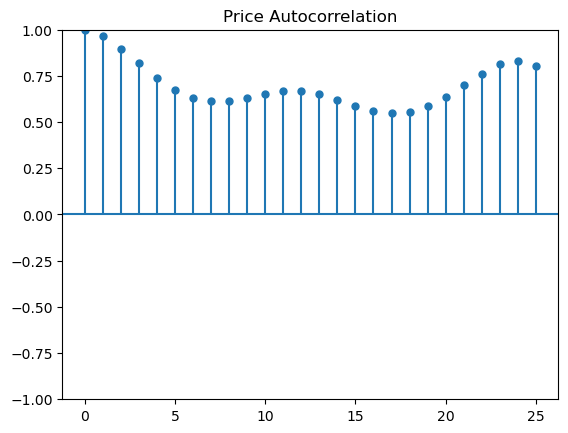

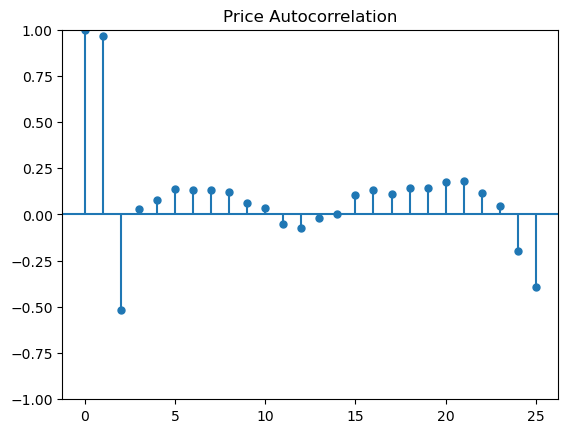

In [121]:
from statsmodels.graphics import tsaplots

fig=tsaplots.plot_acf(df['price actual'], lags=25,title='Price Autocorrelation',alpha=None)
fig.show()

fig=tsaplots.plot_pacf(df['price actual'], lags=25,title='Price Autocorrelation',alpha=None)
fig.show()

In [122]:
df['lag_24']=df['price actual'].shift(24) #we chose to use shift 24, due to the fact that is minimum lag we can take to make one
#day ahead forecast and it has a Partial Autocorrelation absolute value very hight.

df['day']=df['time'].dt.dayofyear

df['day_of_week']=df['time'].dt.weekday

df.replace(np.nan,0,inplace=True)

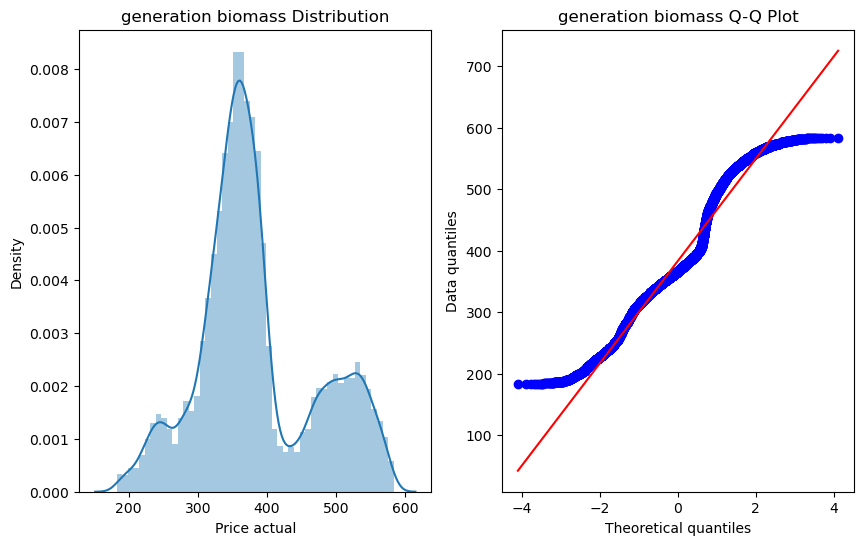

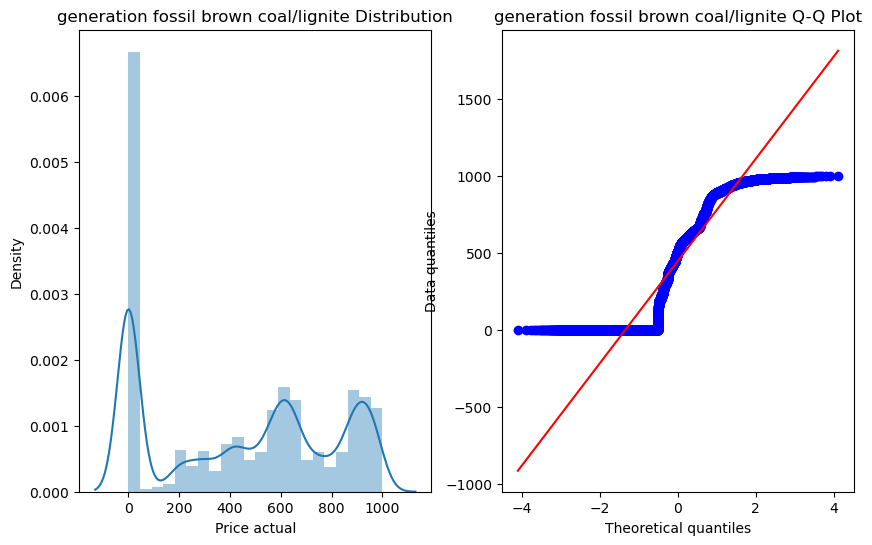

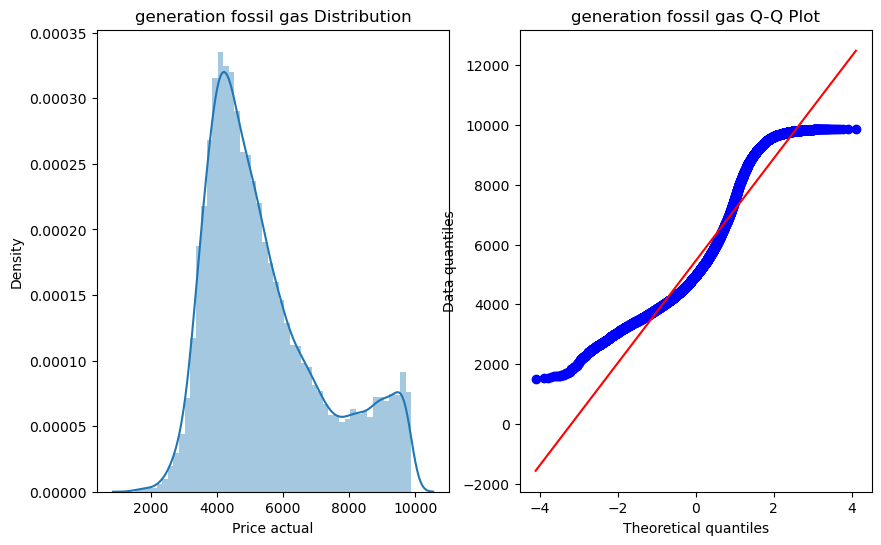

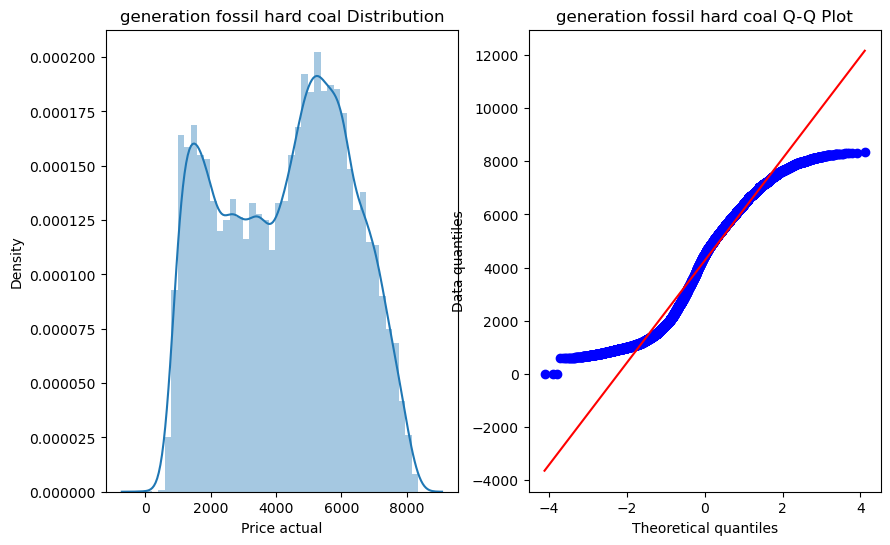

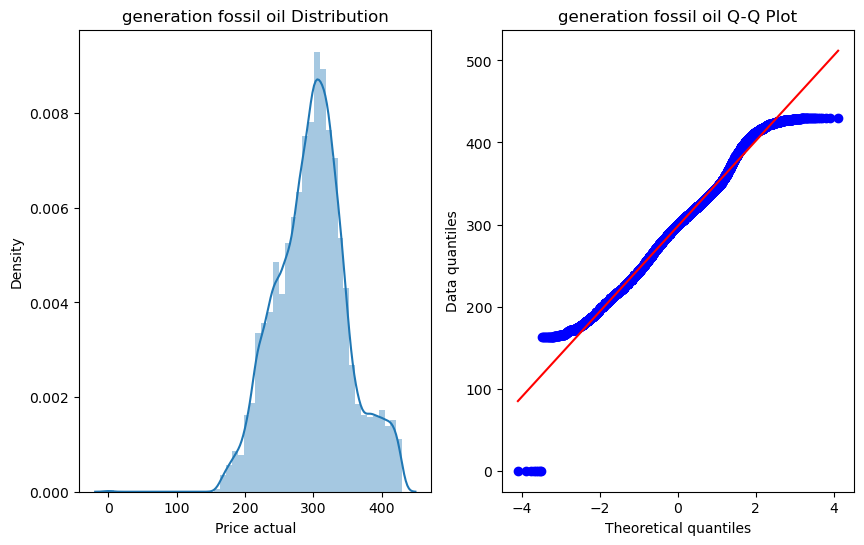

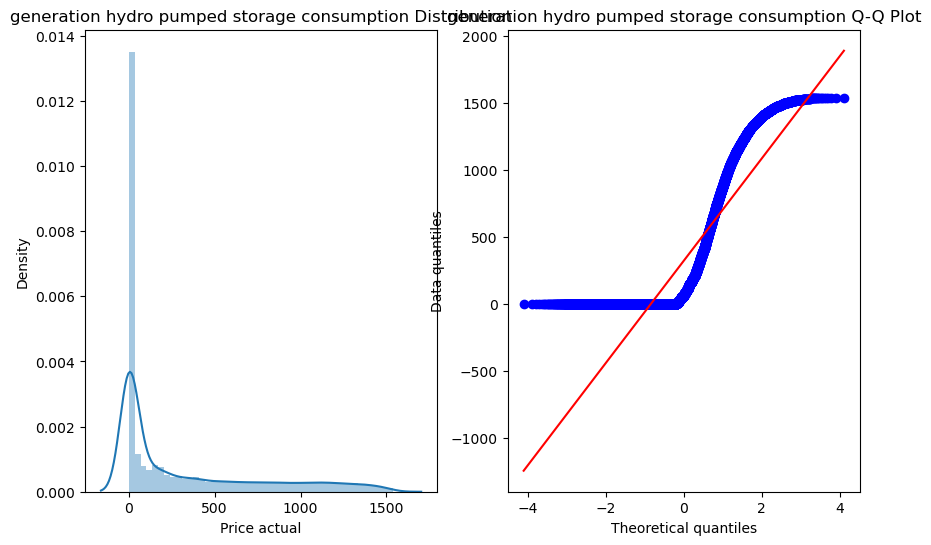

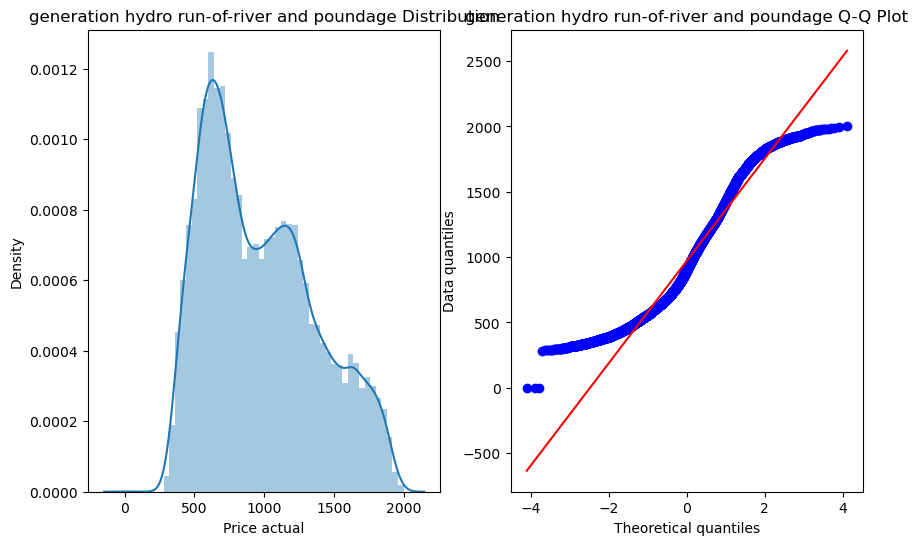

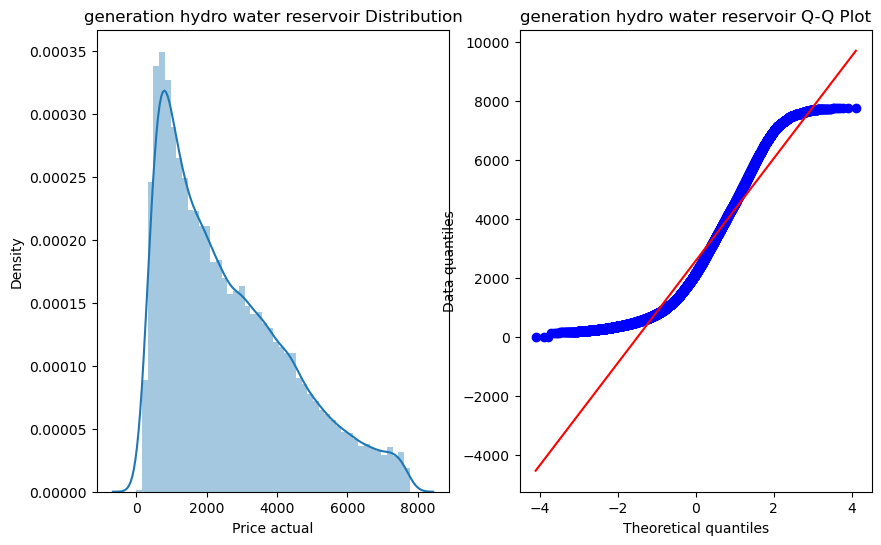

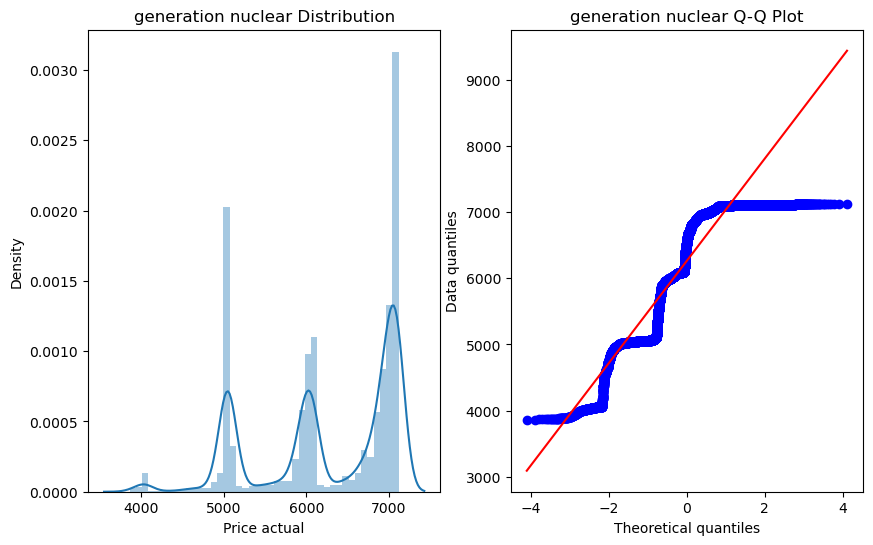

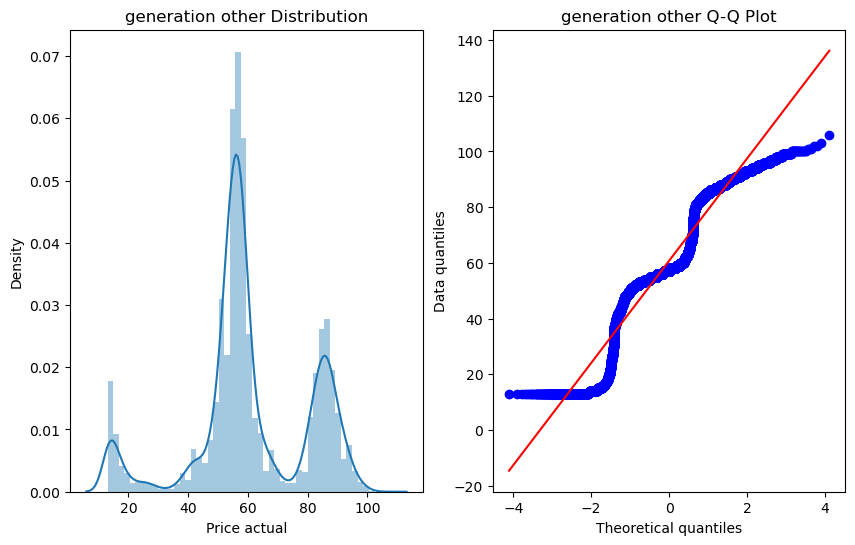

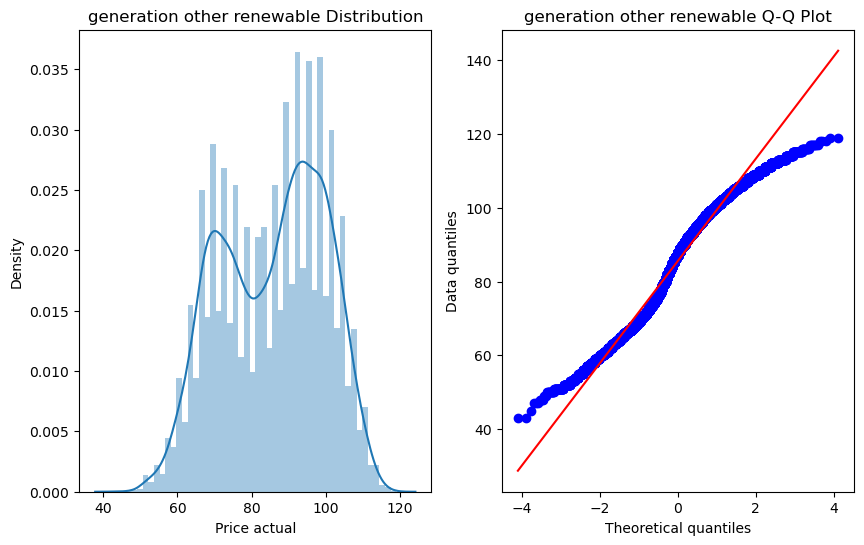

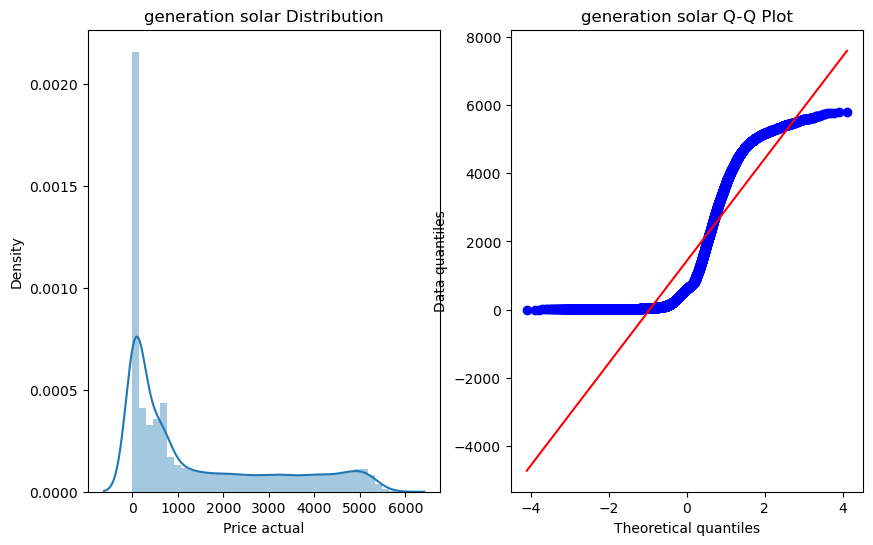

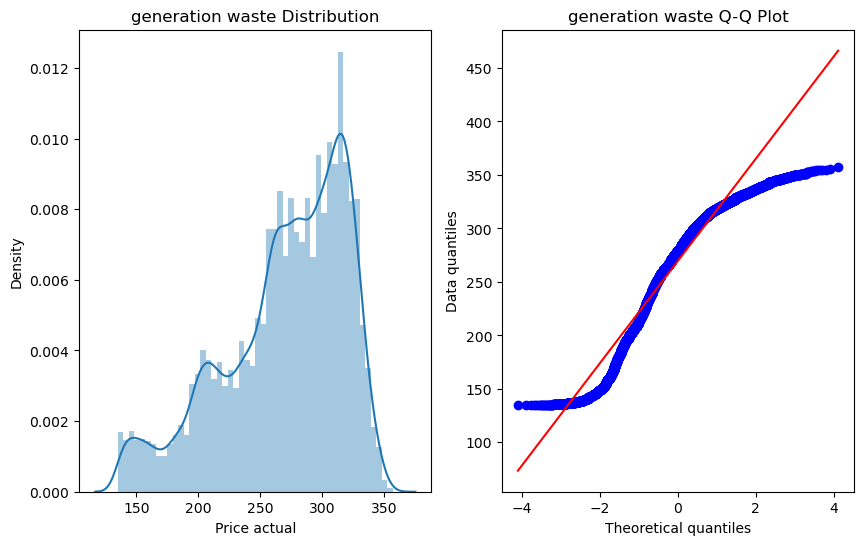

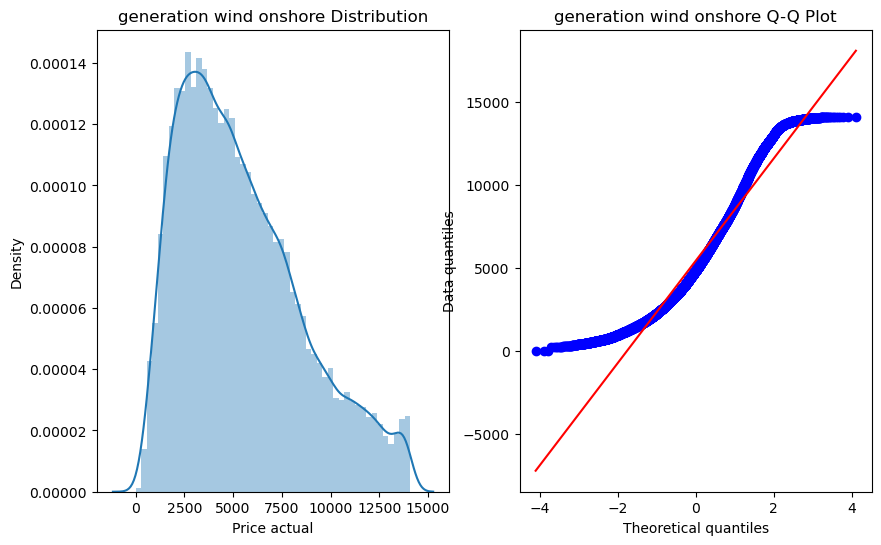

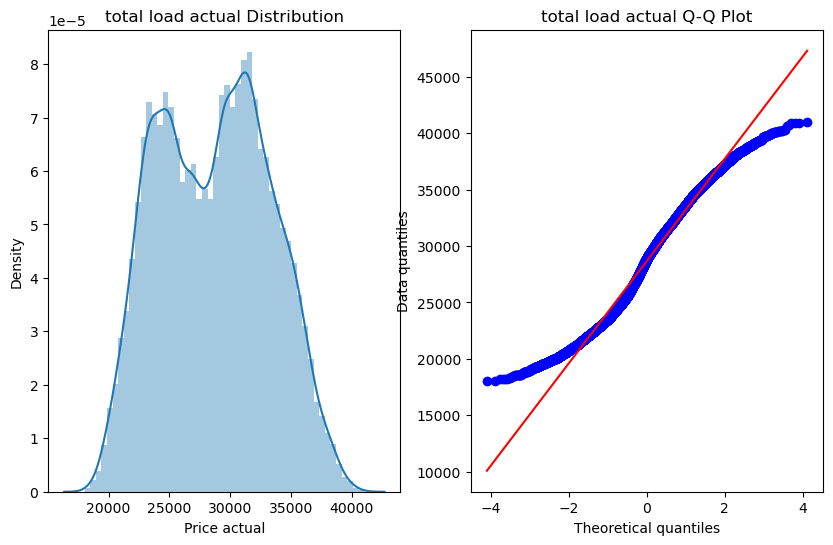

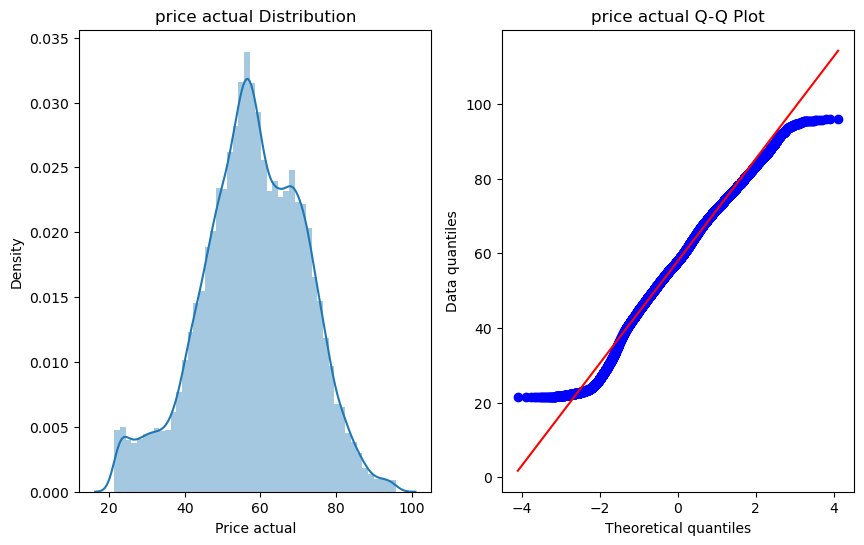

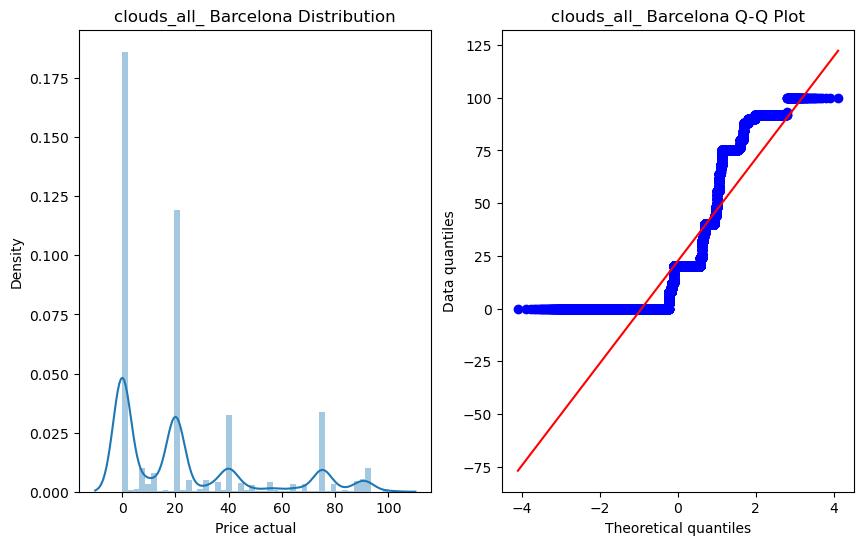

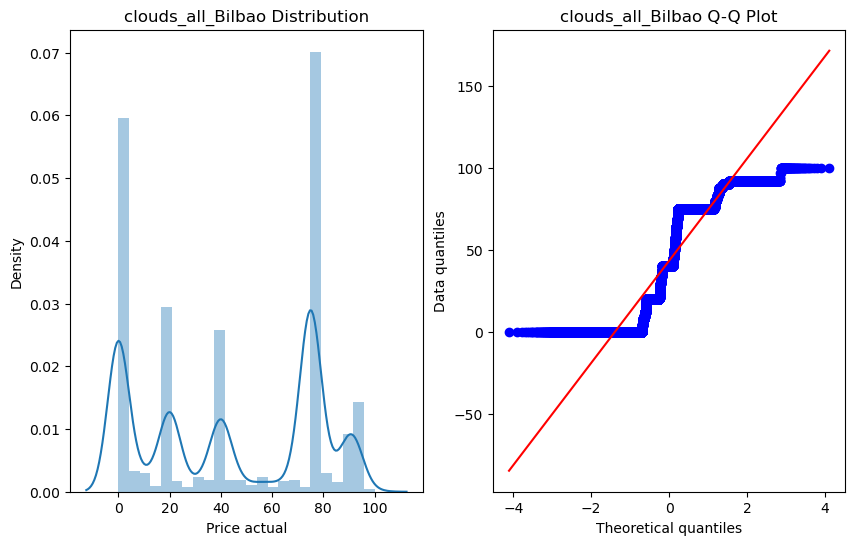

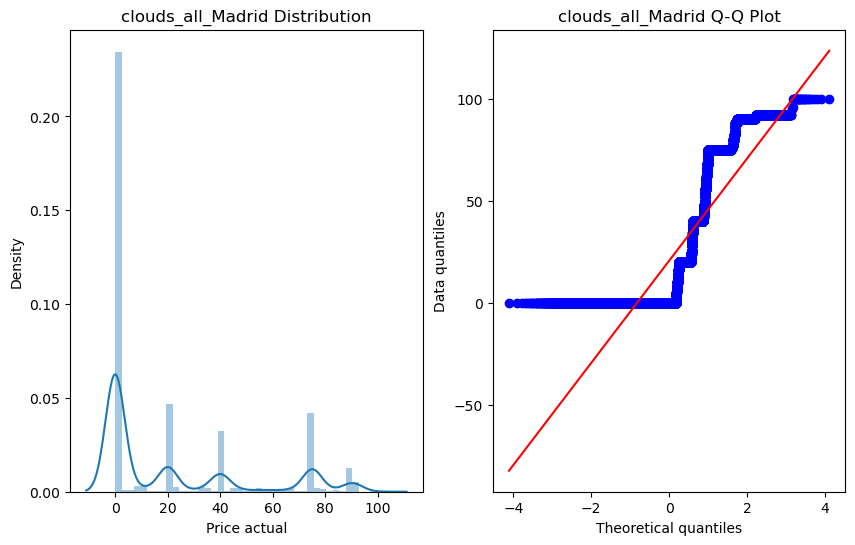

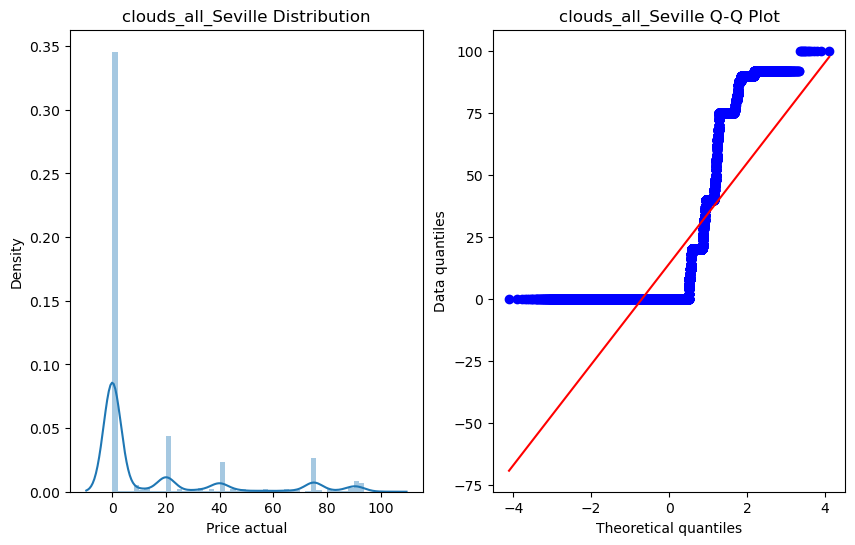

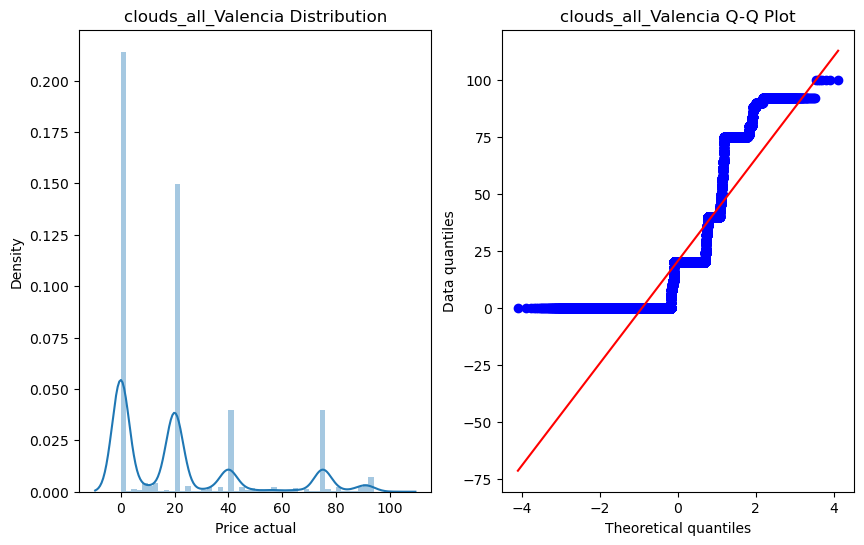

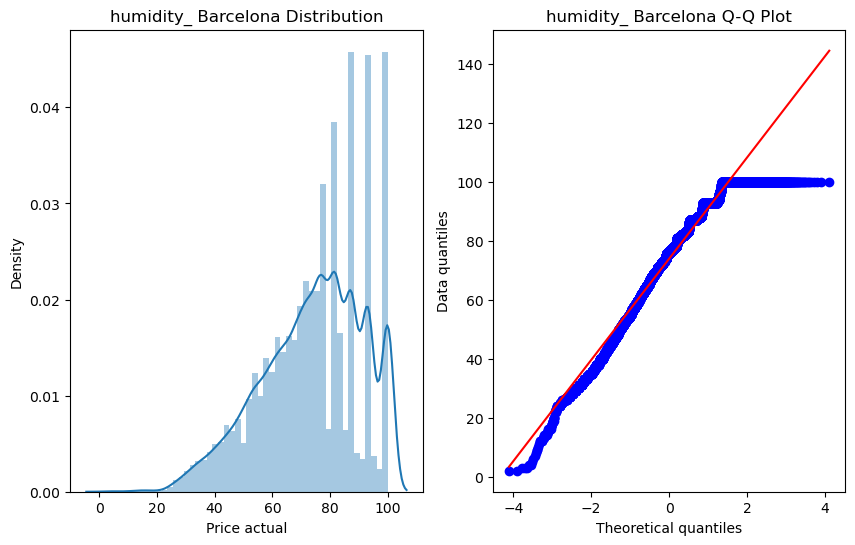

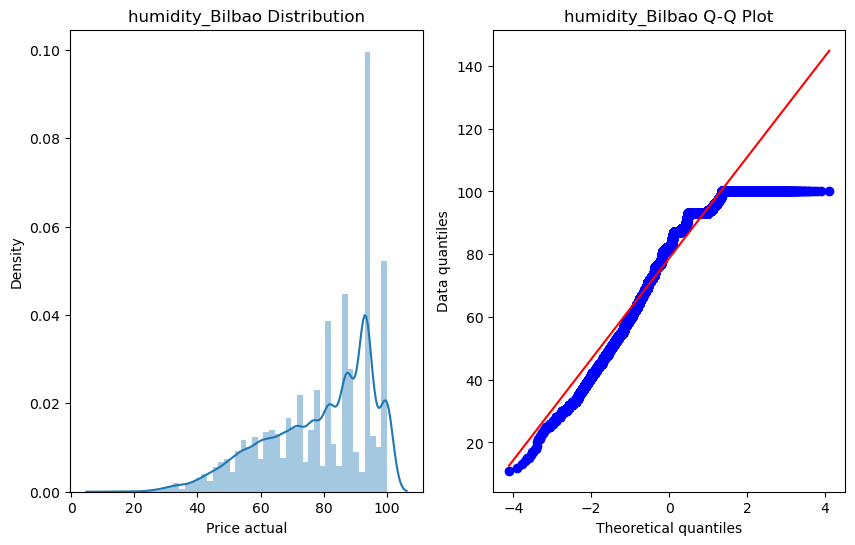

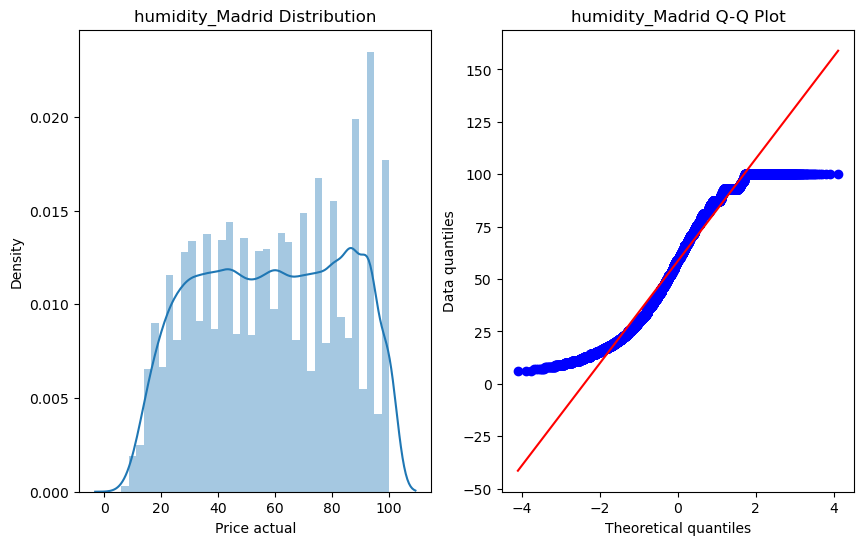

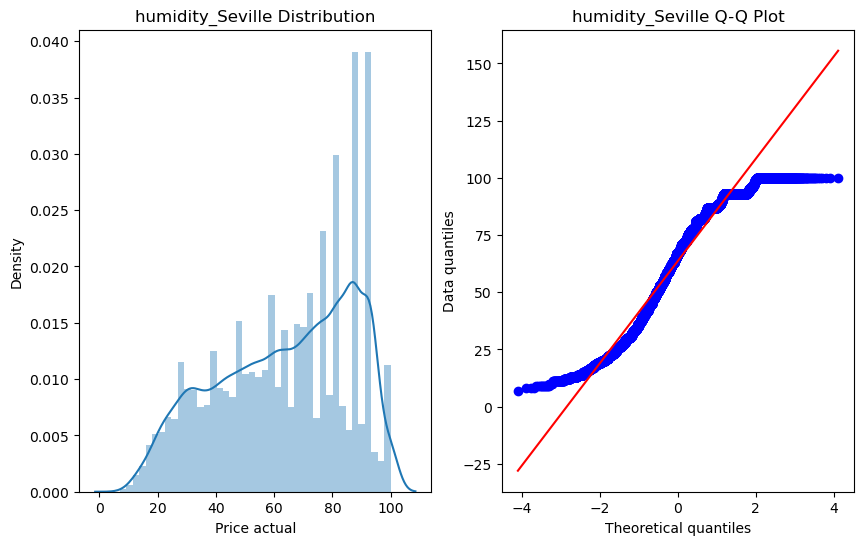

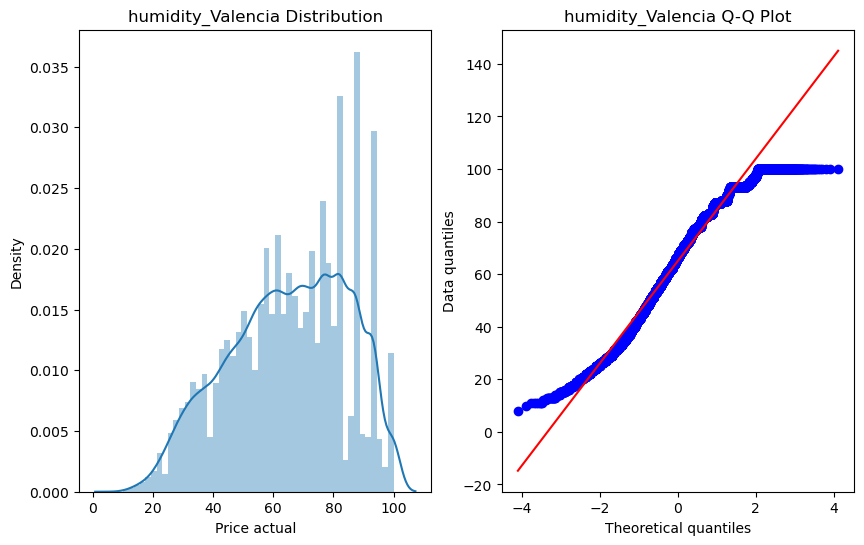

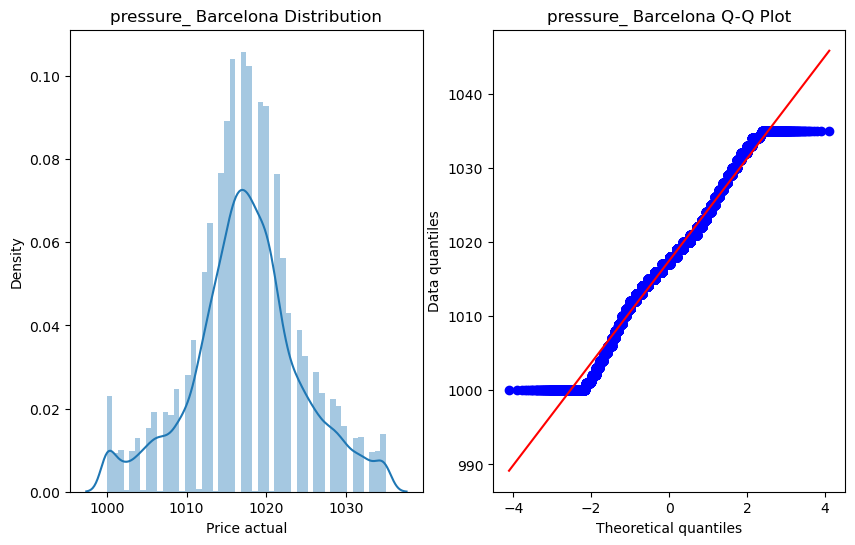

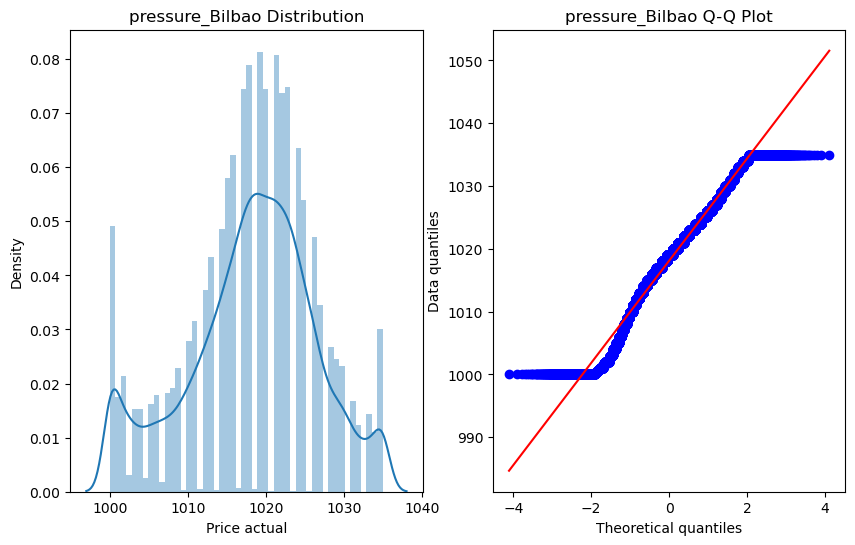

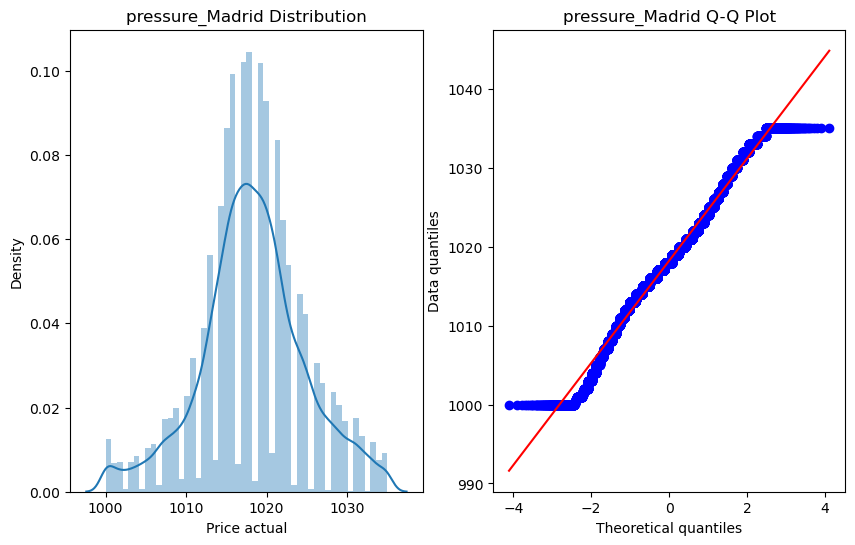

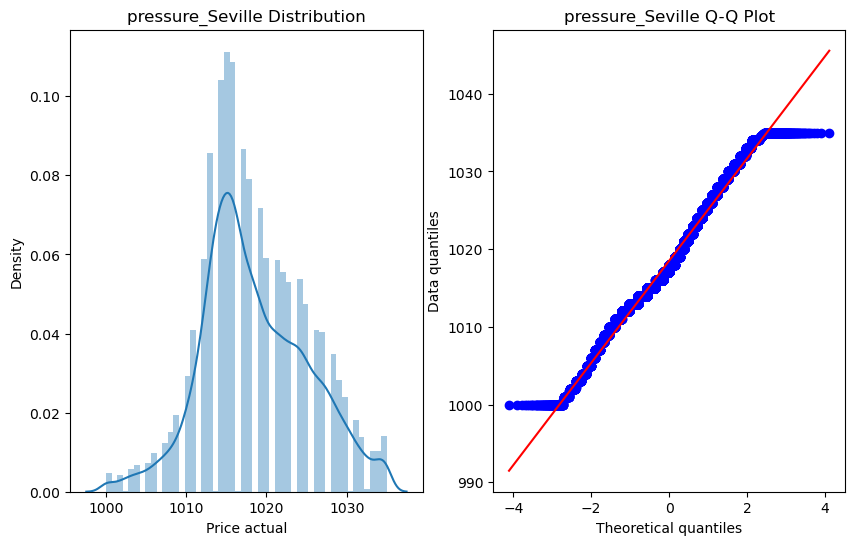

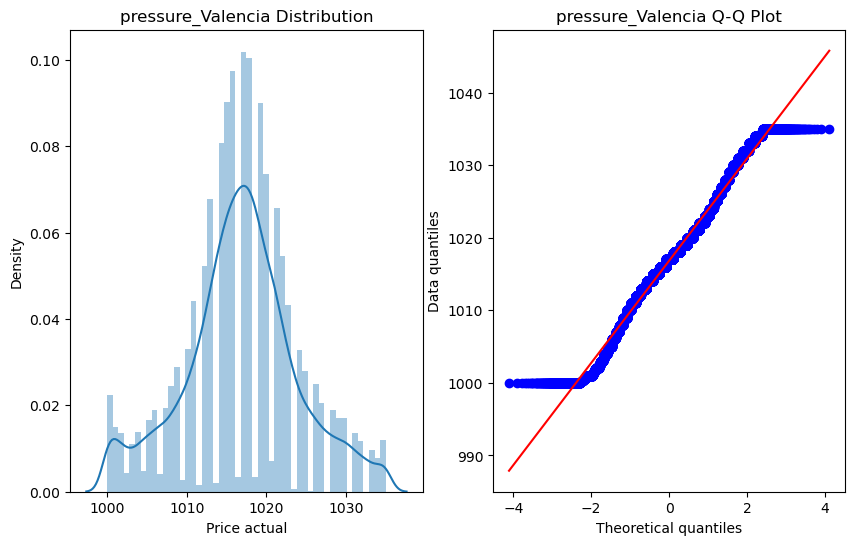

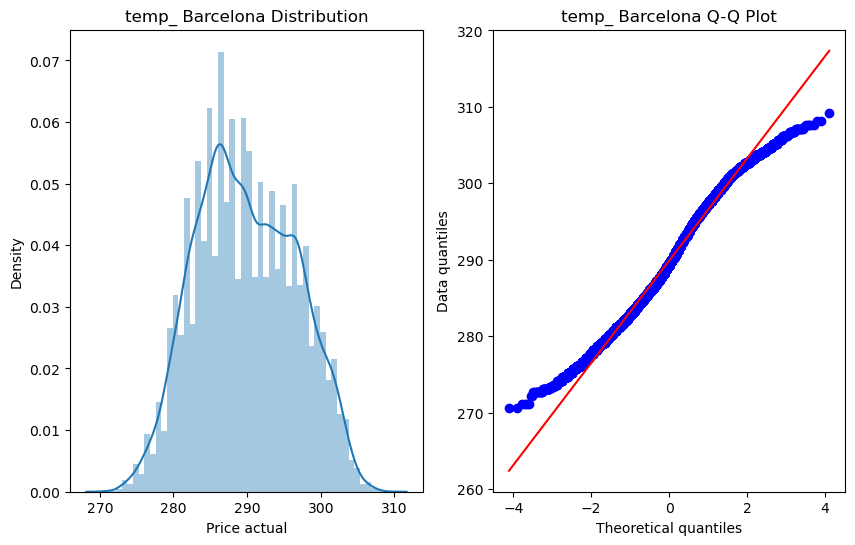

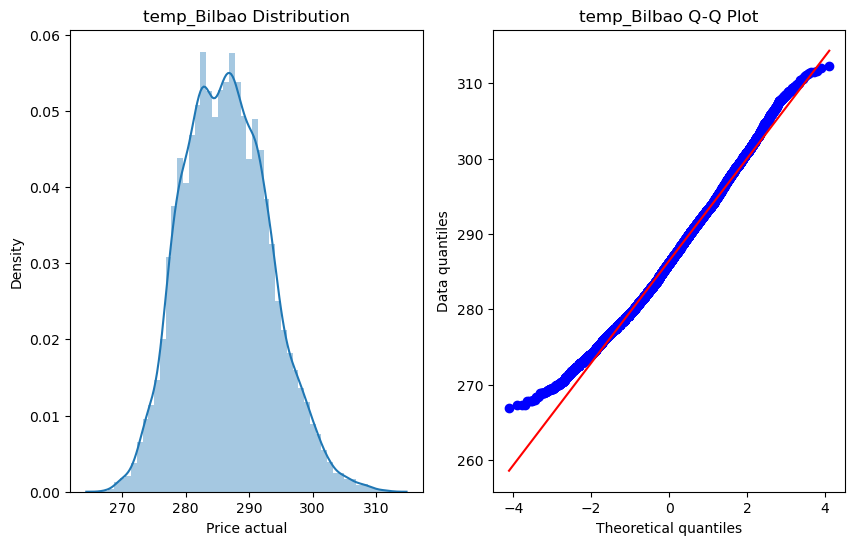

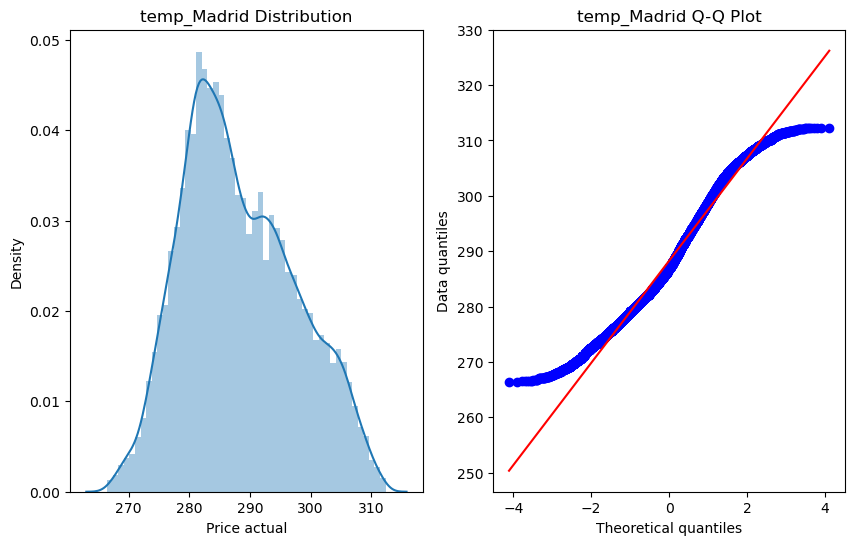

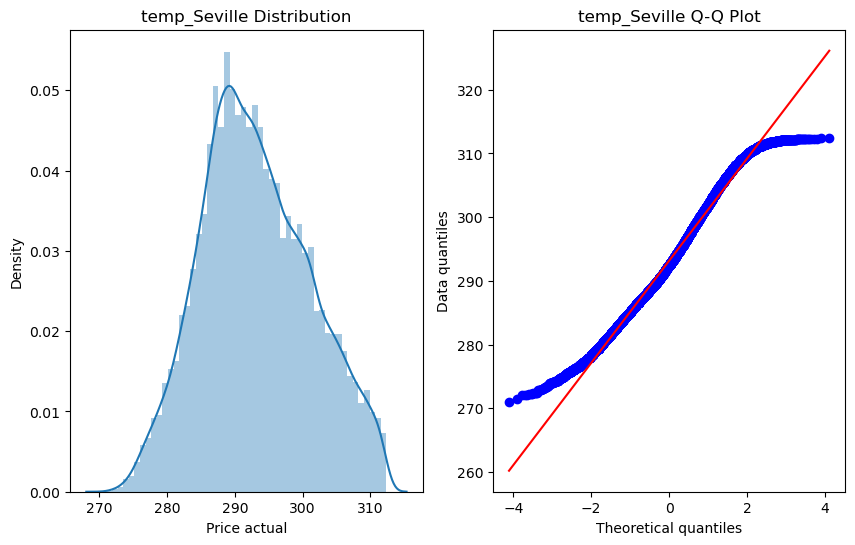

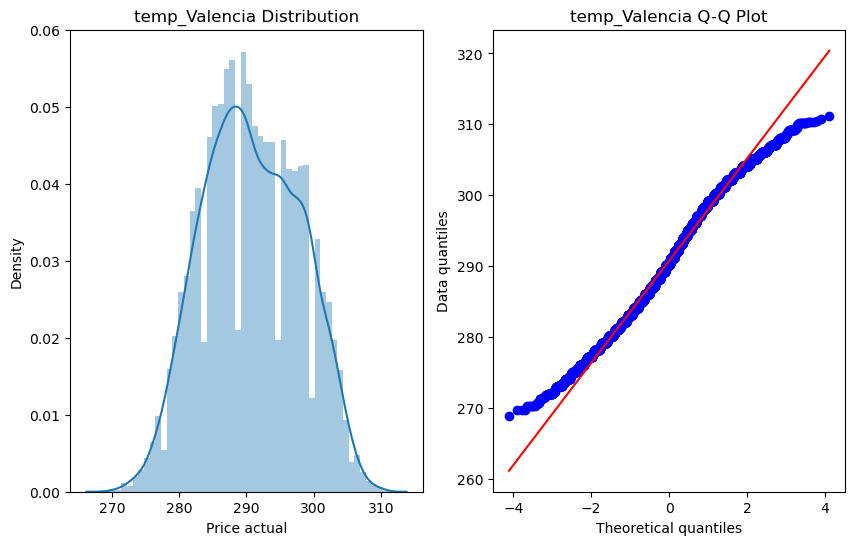

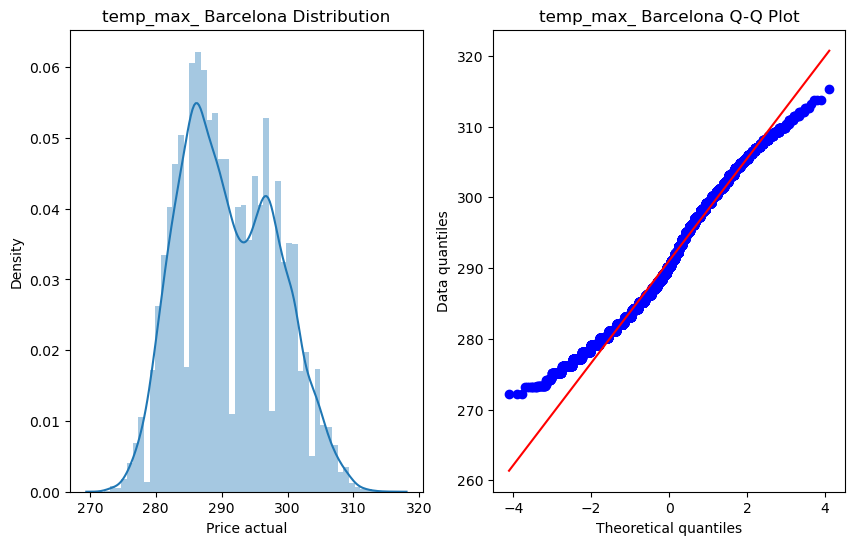

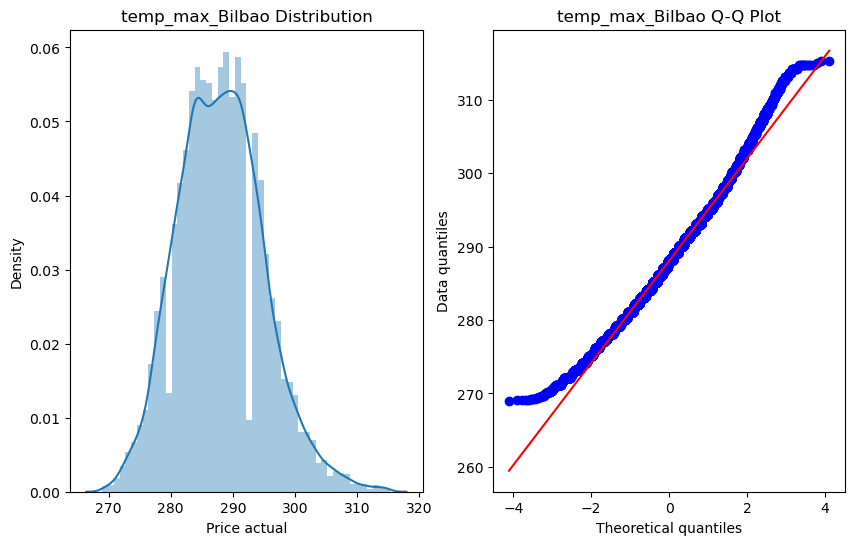

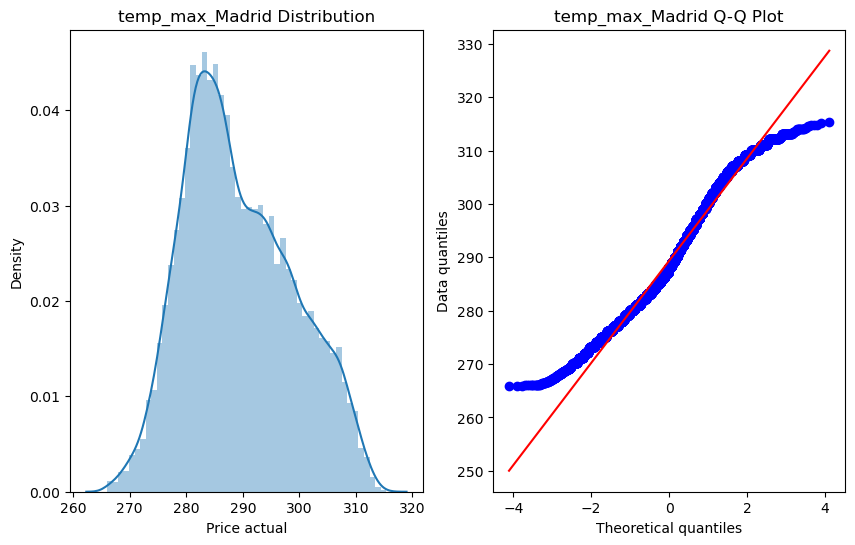

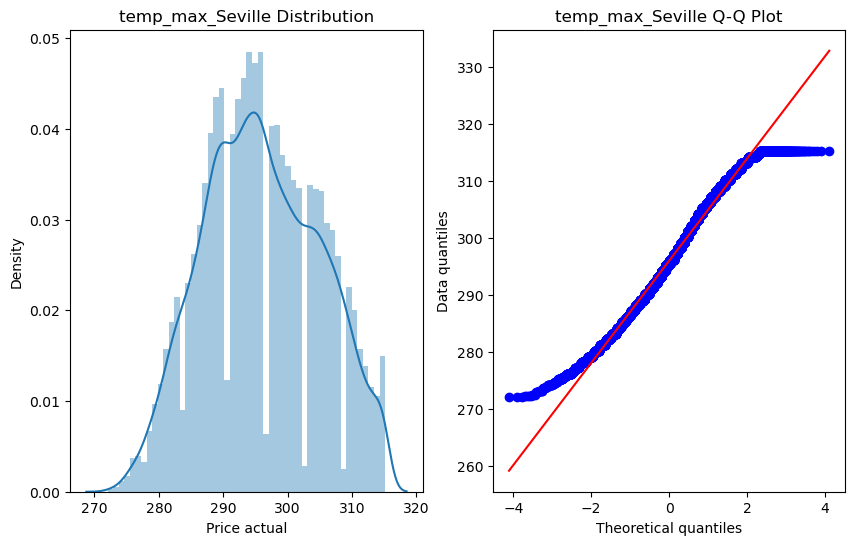

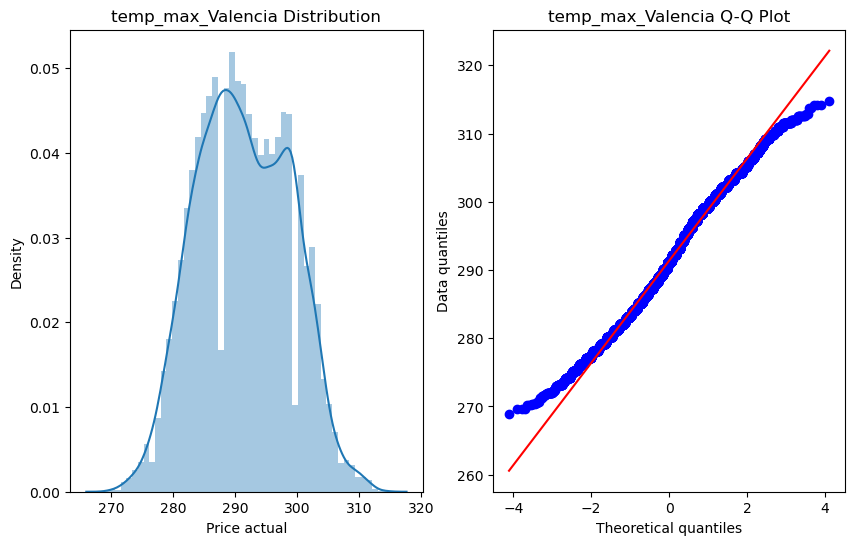

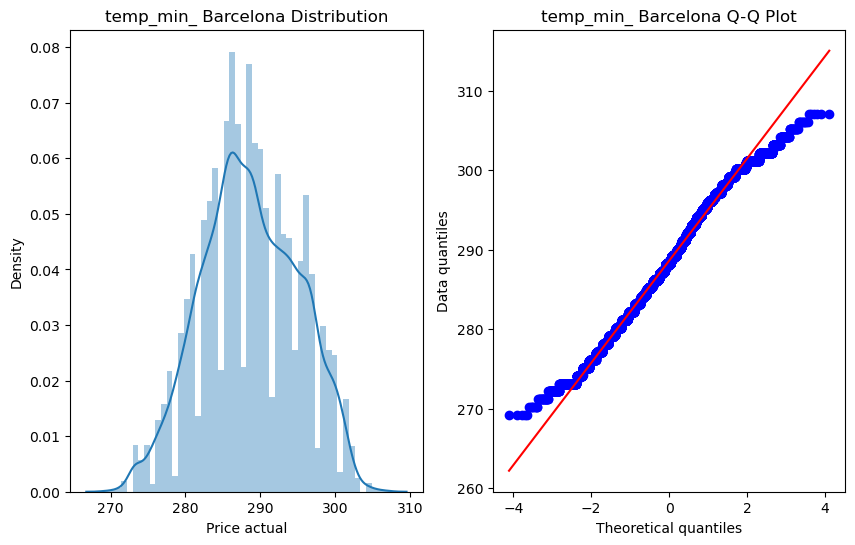

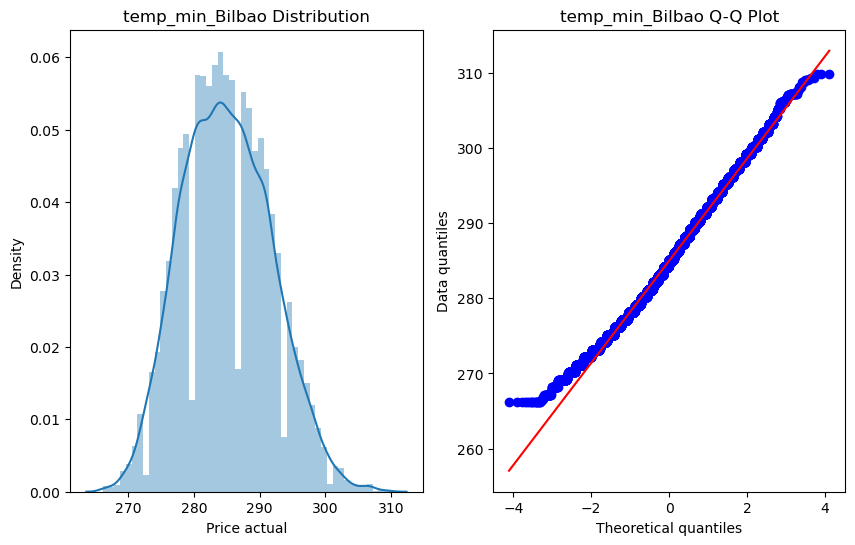

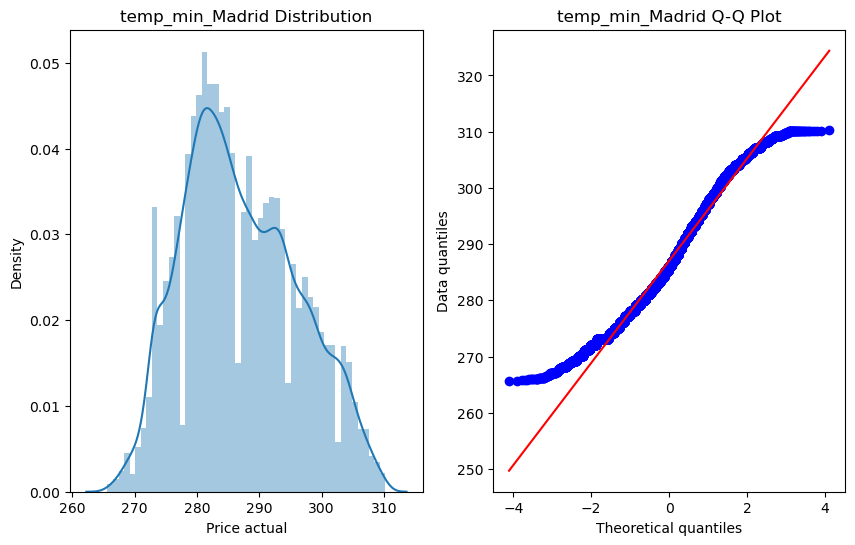

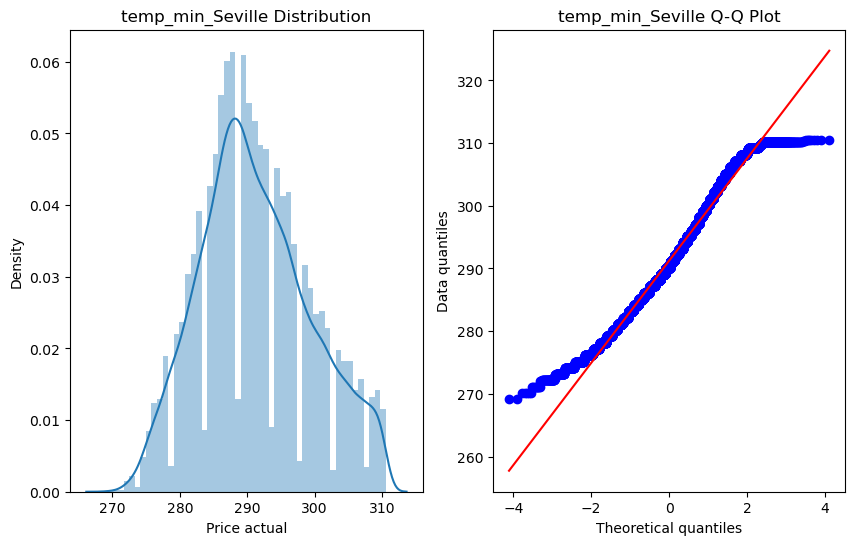

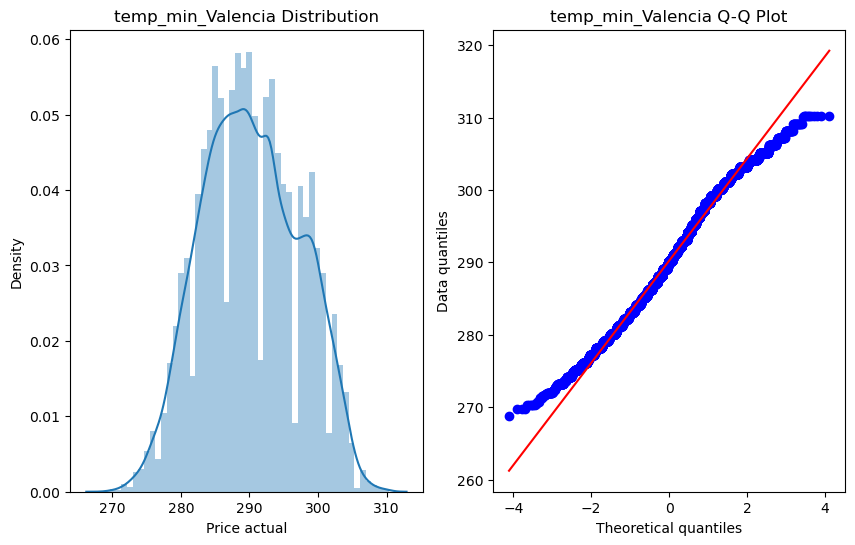

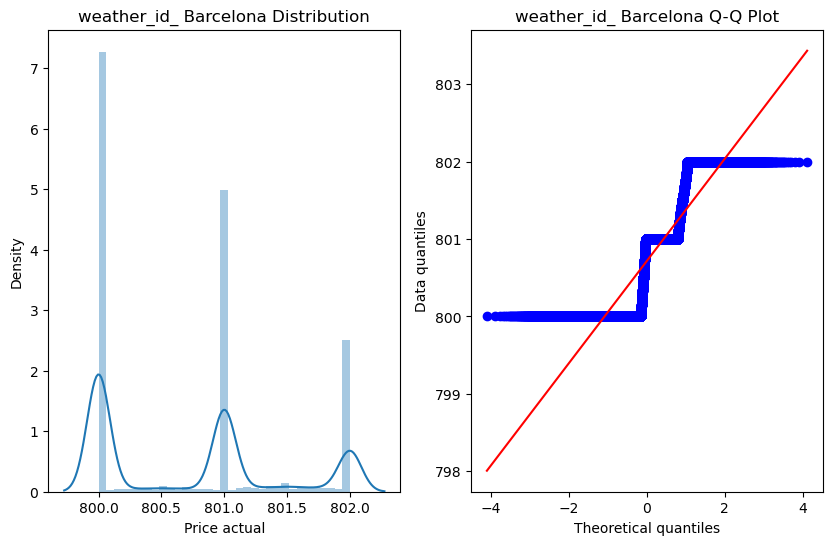

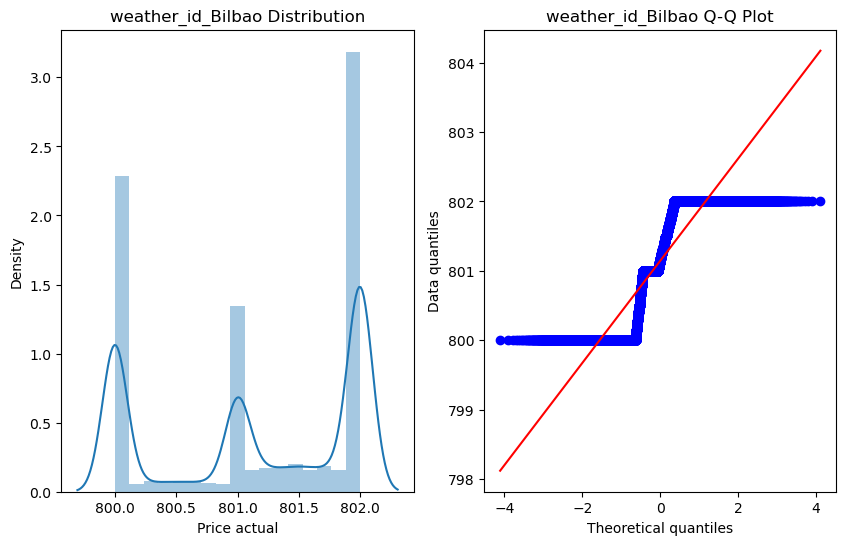

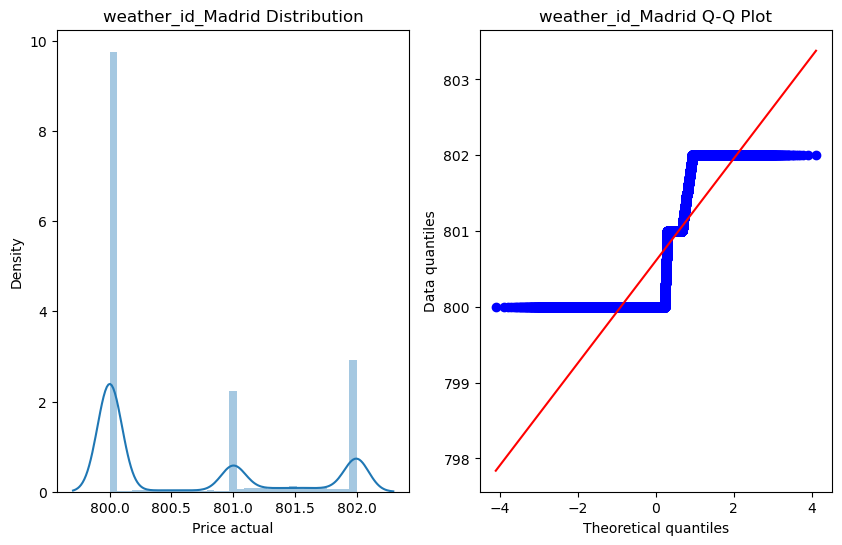

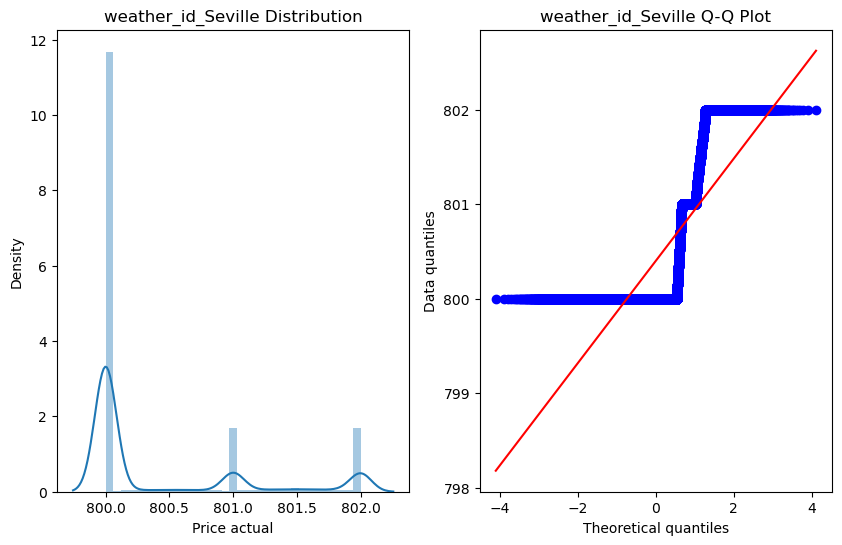

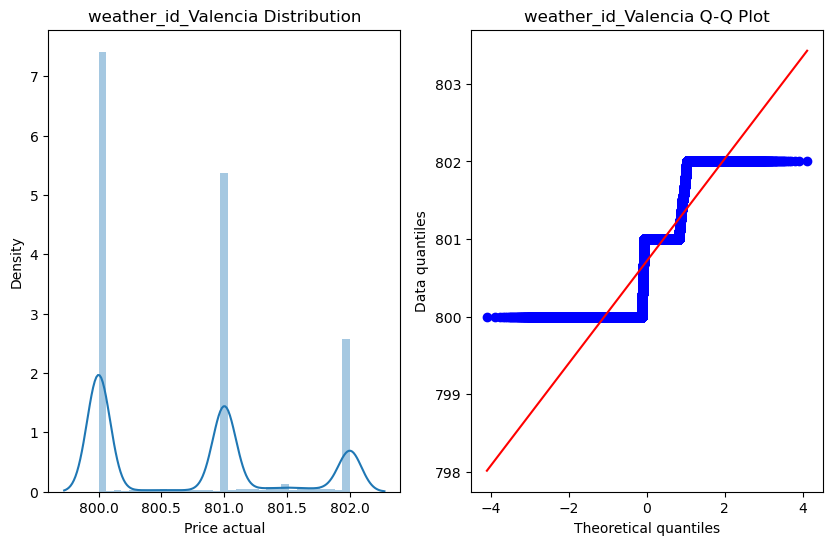

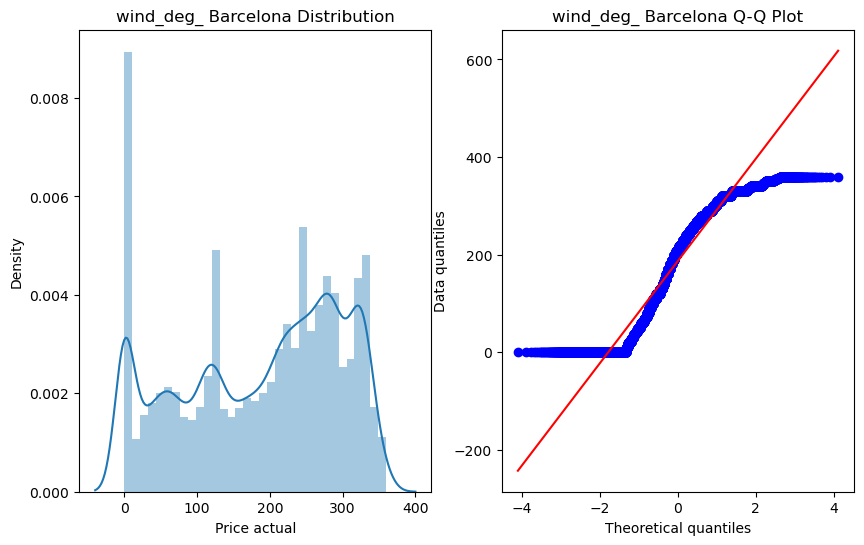

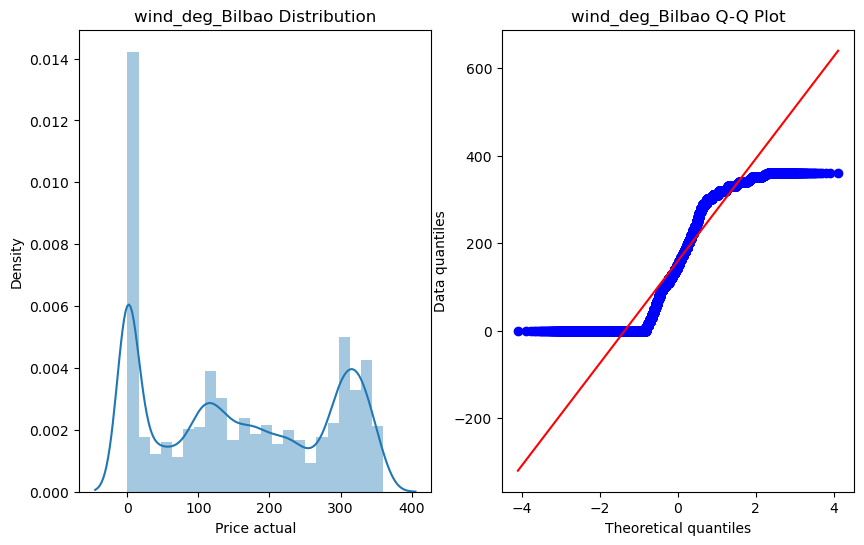

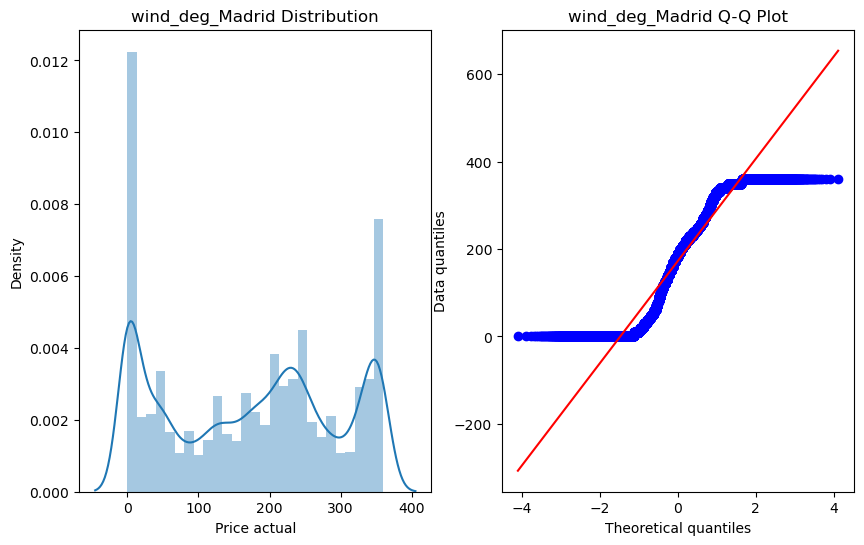

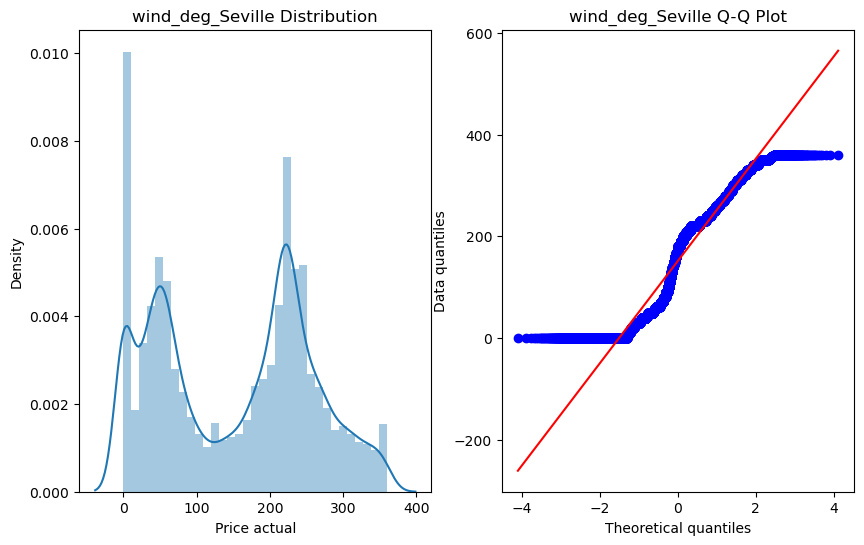

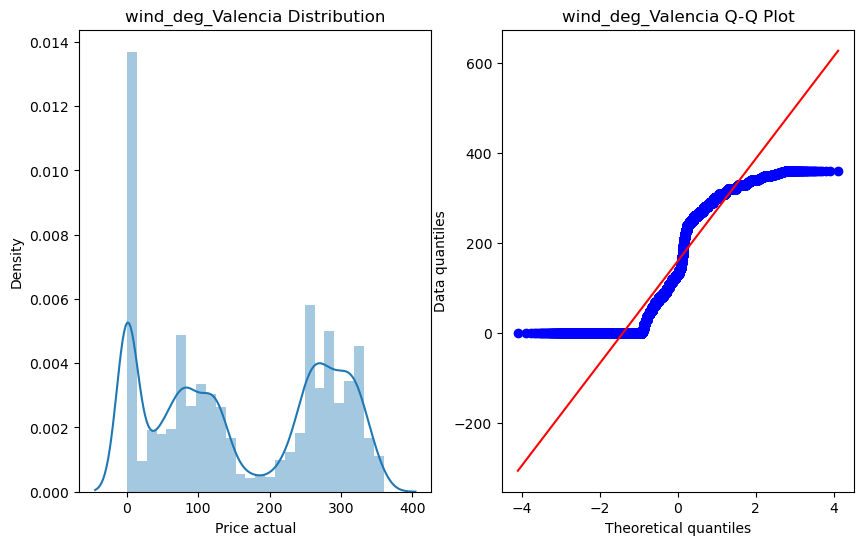

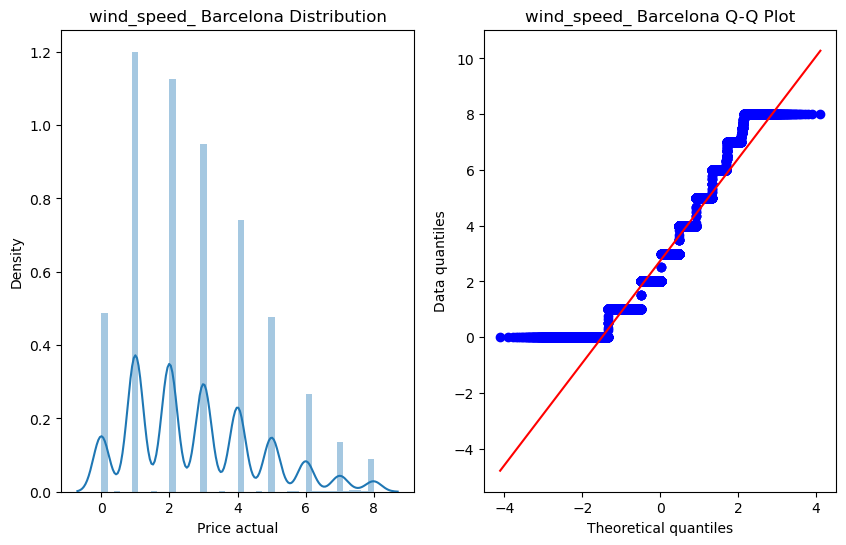

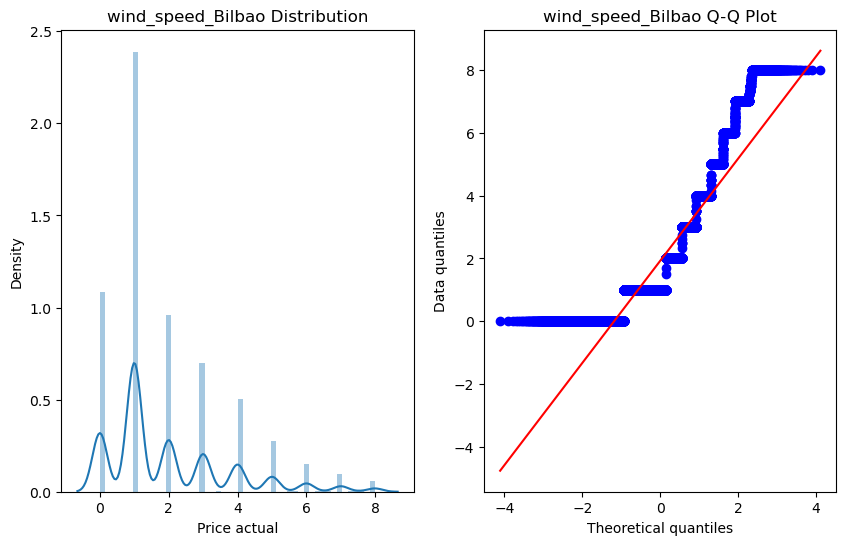

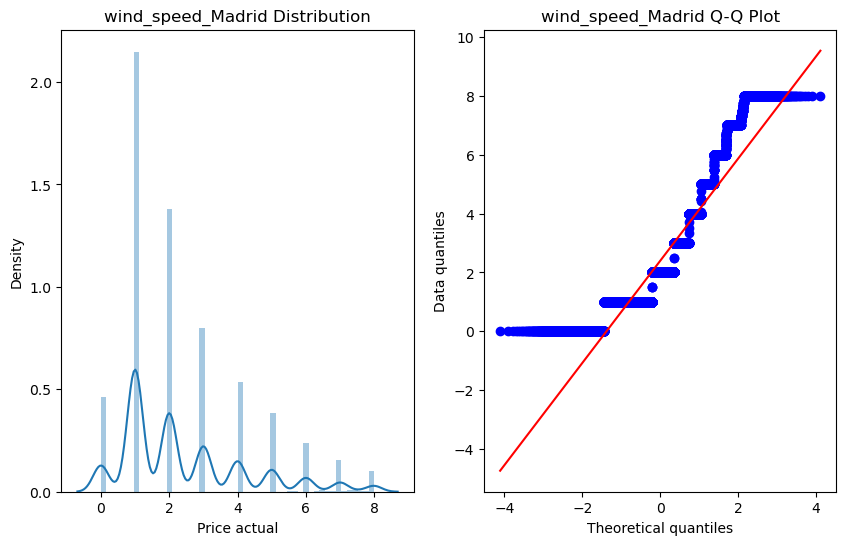

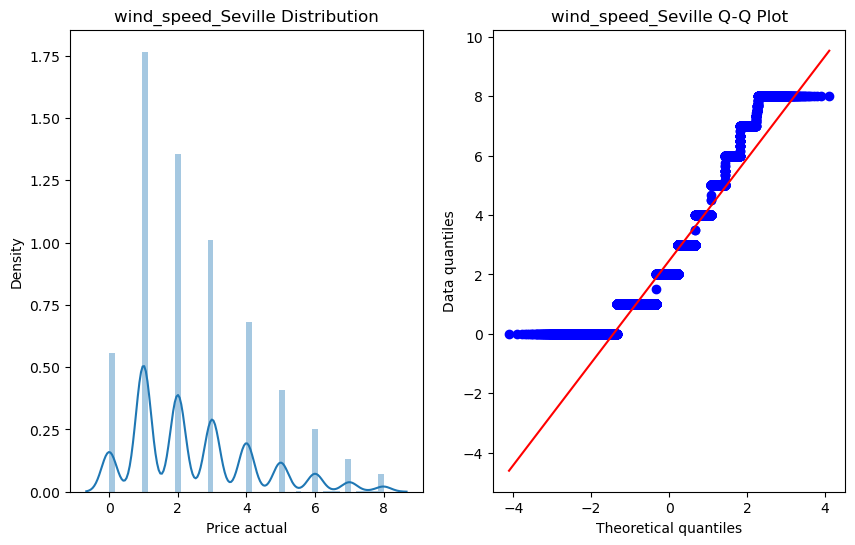

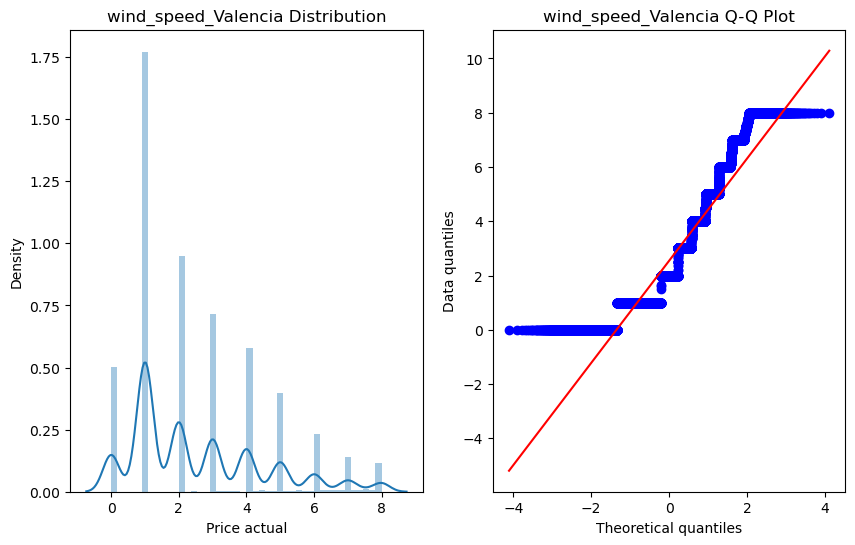

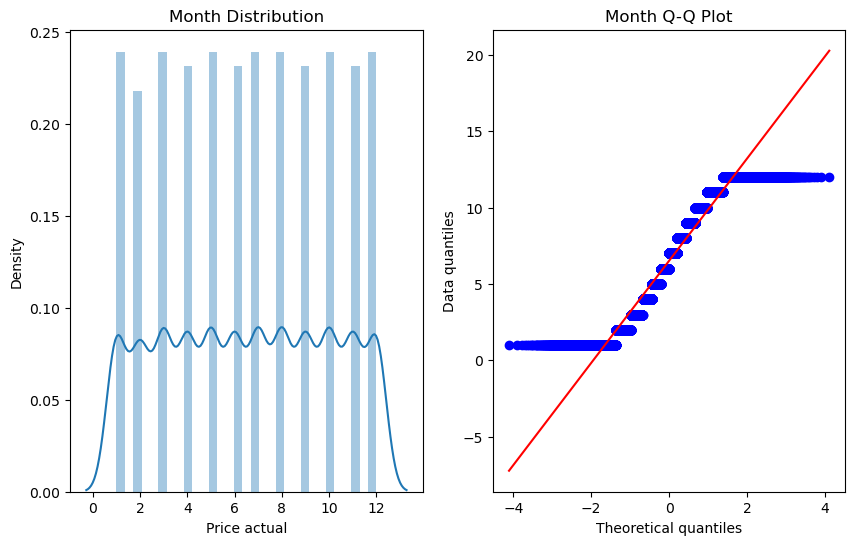

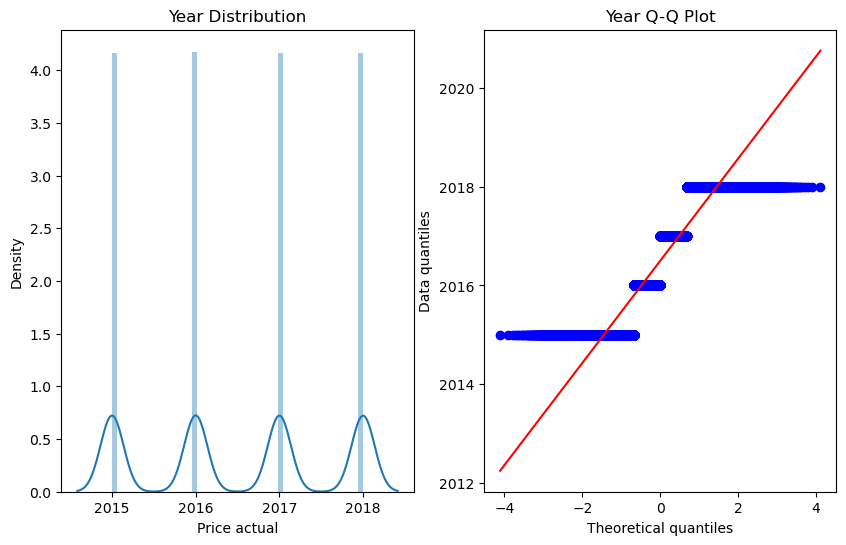

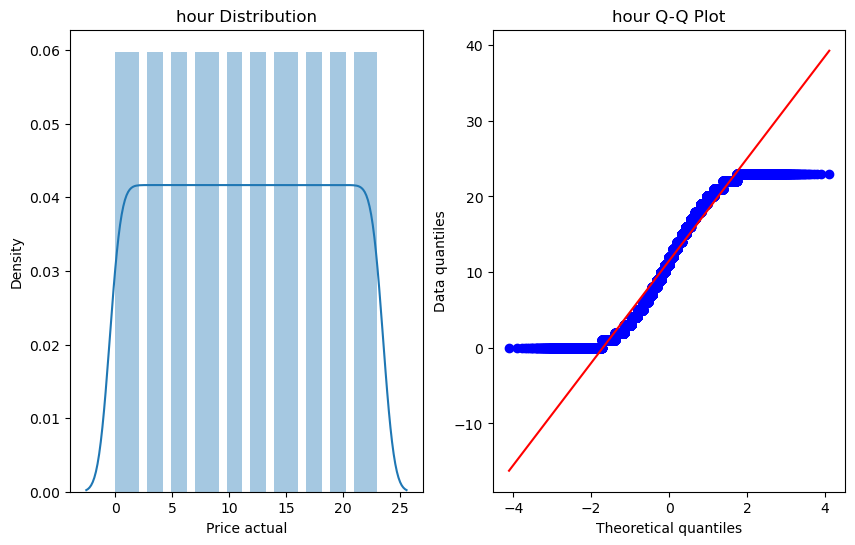

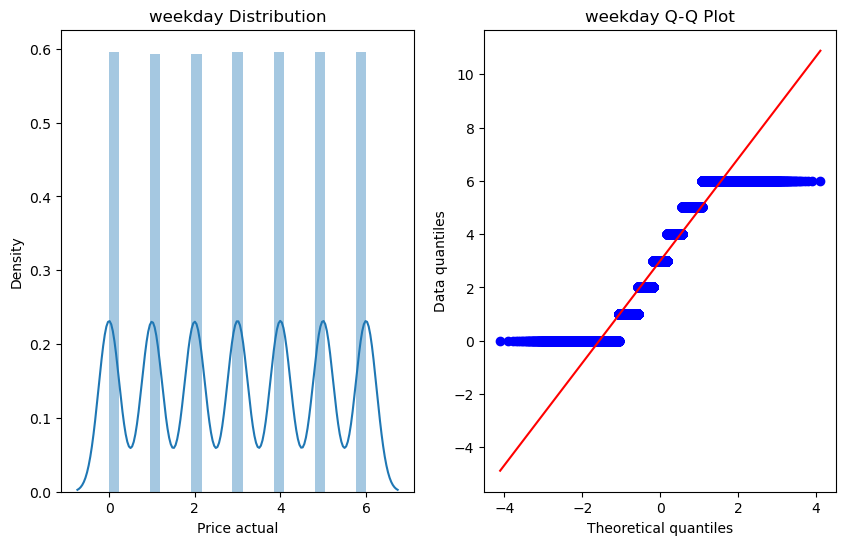

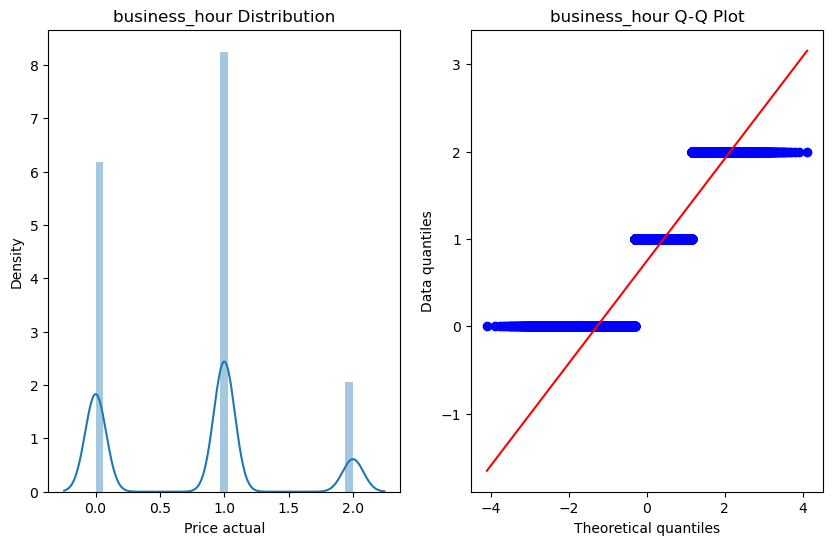

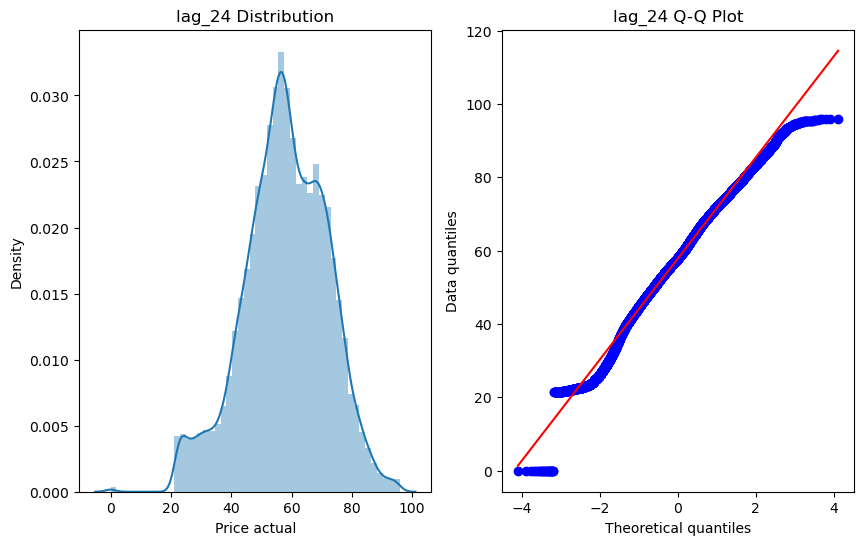

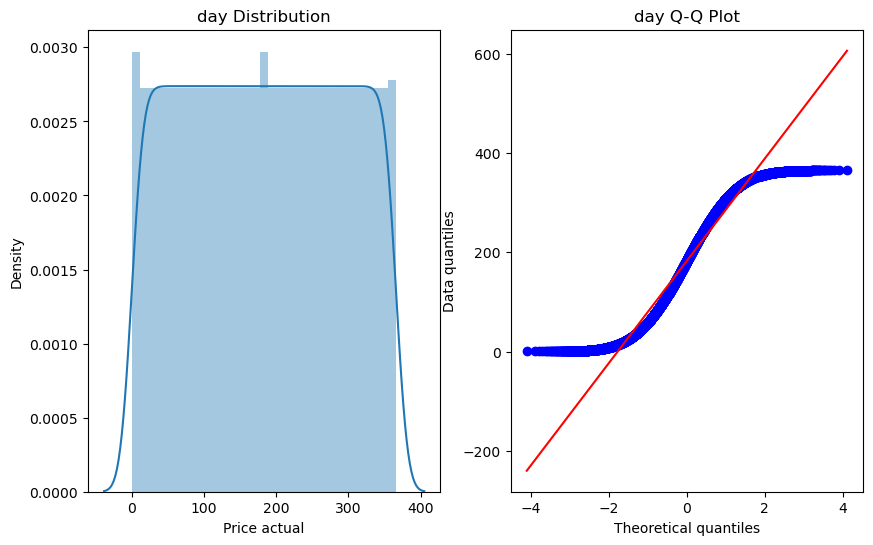

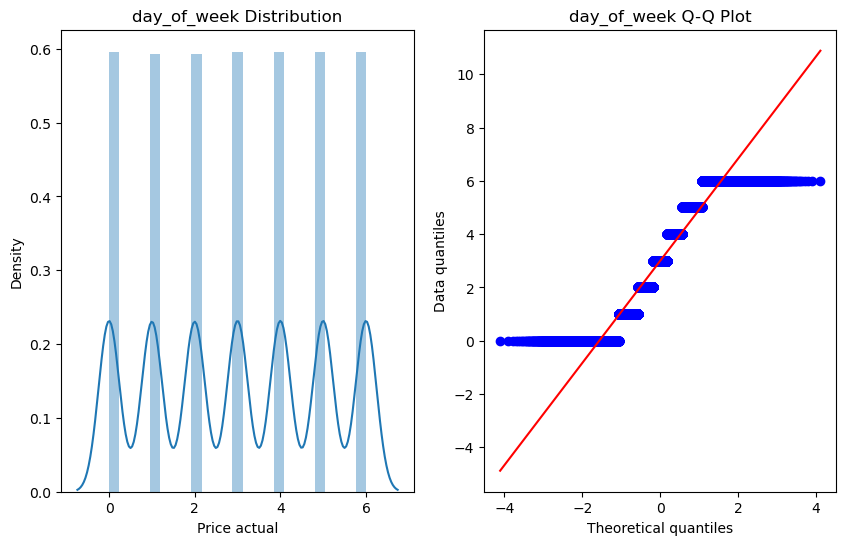

In [123]:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = df.select_dtypes(include=numerics)

for columns in newdf.columns:
    fig=plt.figure(figsize=(10,6))
    plt.subplot(1,2,1) 
    sns.distplot(newdf[columns].dropna())
    plt.title(f"{columns} Distribution")
    plt.xlabel('Price actual')
    plt.subplot(1,2,2)
    stats.probplot(newdf[columns], dist="norm", plot=plt)
    plt.title(f"{columns} Q-Q Plot")
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Data quantiles')
    plt.show()
    fig.show()

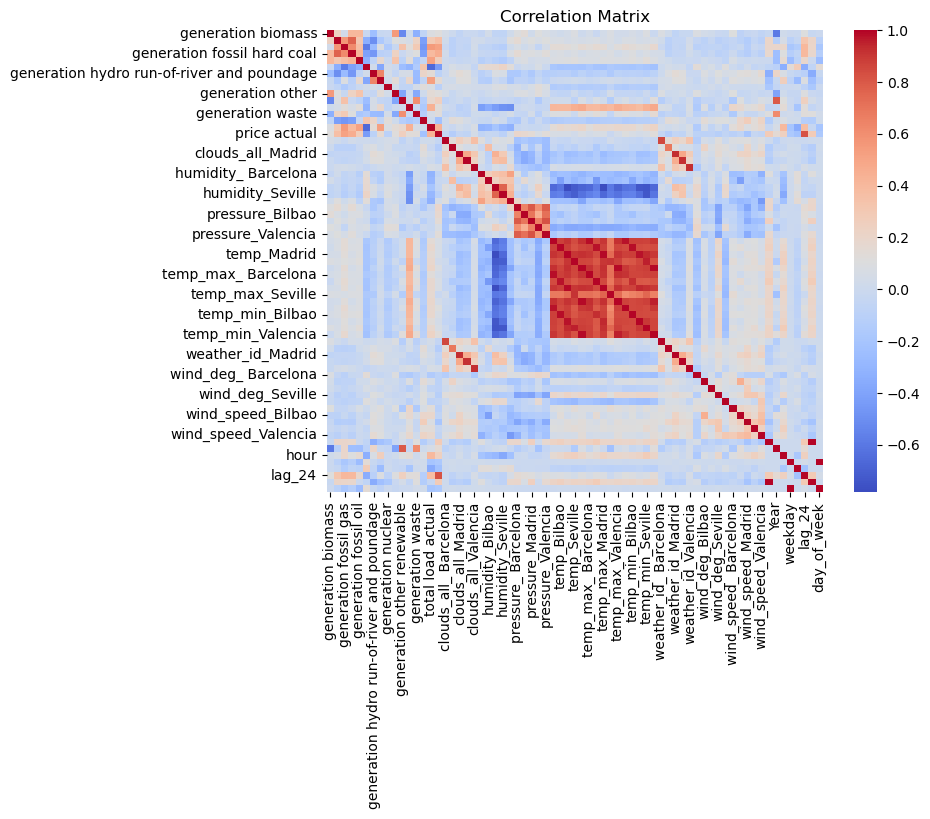

In [124]:
try: 
    df=df.drop(['date'],axis=1)
except:
    pass
correlation_matrix = ((df.set_index('time')-df.set_index('time').mean())/df.set_index('time').std()).corr(method='spearman')

# Visualize the correlation matrixs
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [125]:
print(correlation_matrix['price actual'].loc[(np.abs(correlation_matrix['price actual'])>0.2)])

generation fossil brown coal/lignite           0.366270
generation fossil gas                          0.515051
generation fossil hard coal                    0.459927
generation fossil oil                          0.268123
generation hydro pumped storage consumption   -0.437657
generation other renewable                     0.248371
generation wind onshore                       -0.219568
total load actual                              0.435243
price actual                                   1.000000
Month                                          0.288141
hour                                           0.246935
business_hour                                 -0.220359
lag_24                                         0.825365
day                                            0.287459
Name: price actual, dtype: float64


For selecting features we will just use a method based on clustering. Then we will compute distance matrix between features with Ward method.
Idea is basic: clustering feature and then selecting the most rapresentative features with highest variance in the cluster.

Number of original features is: 69
Number of selected feature is: 34


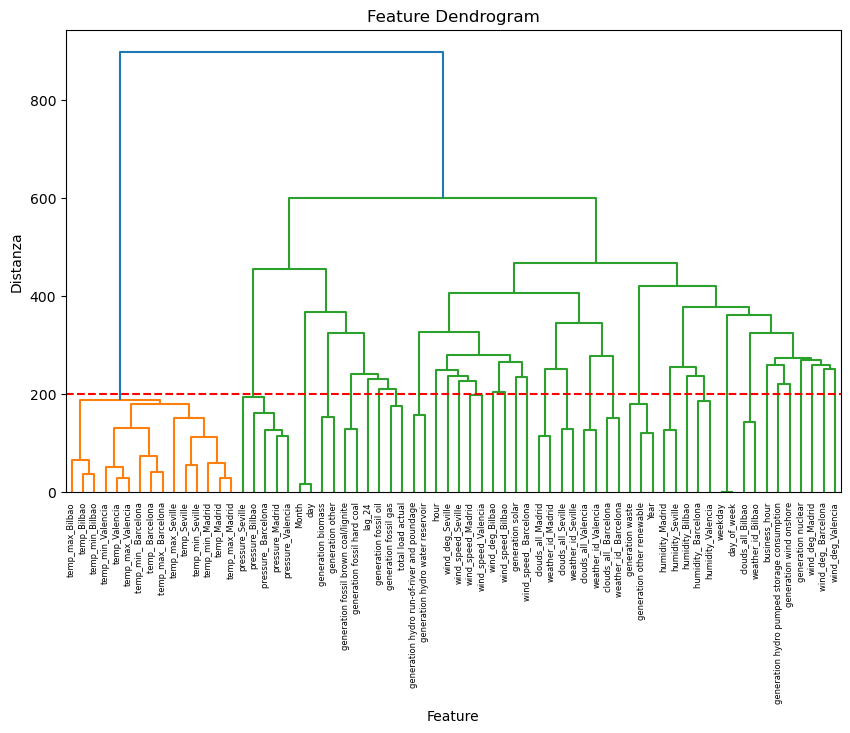

In [126]:
#let us standarize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(['price actual'],axis=1).set_index('time'))

fig=plt.figure(figsize=(10,6))
#let us compute linkage
Z = linkage(df_scaled.T, method='ward')

# Crea il dendrogramma
dendrogram(Z, labels=df.drop(['price actual'],axis=1).set_index('time').columns, leaf_rotation=90)
plt.title('Feature Dendrogram')
plt.xlabel('Feature')
plt.ylabel('Distanza')

# Cut Dendrogram to create clusters
max_d =200.0  # Max distance threshold
clusters = fcluster(Z, max_d, criterion='distance')

plt.axhline(y=max_d, color='r', linestyle='--', label='feature treshold')
fig.show()

#select most rapresentative feature in cluster
selected_features = []
for cluster in np.unique(clusters):
    cluster_features = df.drop(['price actual'],axis=1).set_index('time').columns[clusters == cluster]
    # Select feature with maxinmum variance
    variances =  df.drop(['price actual'],axis=1).set_index('time')[cluster_features].var()
    selected_feature = variances.idxmax()
    selected_features.append(selected_feature)

print("Number of original features is:", (df.set_index('time')).shape[1])

print("Number of selected feature is:", len(selected_features))


Another valid way to obtain dimension reduction is to use PCA. PCA is a famouse technique based on computing eigenvalues of feature's covariance matrix. Here I decided to use n_components to 0.90. This means that we will only take the variables that contribute 90 % of the total variance of principal components (PC).

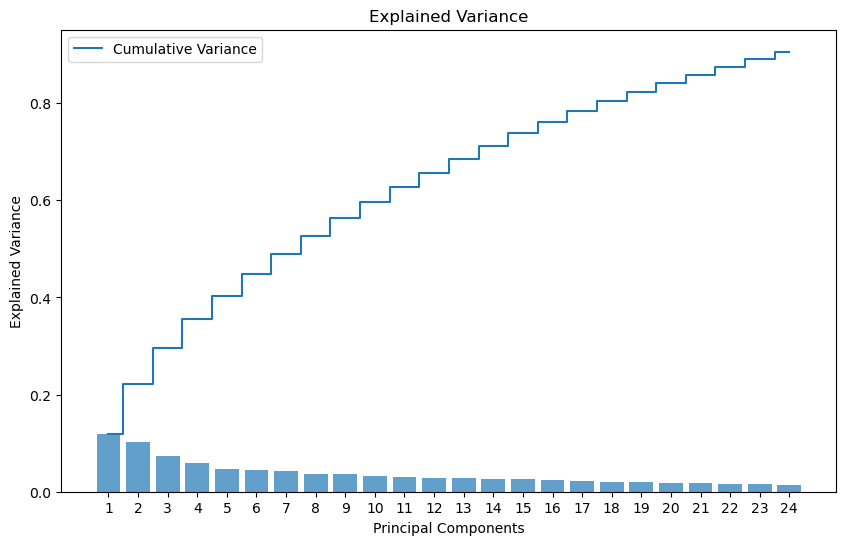

PC_1      PC_2      PC_3      PC_4      PC_5      PC_6      PC_7  \
0 -4.468708  0.343368 -2.839919 -1.640551 -0.179682 -0.486324 -1.592908   
1 -4.612835  0.576136 -3.005442 -1.320973  0.161255 -0.654716 -1.829235   
2 -5.021978  0.716734 -3.372490 -1.259263  0.389808 -0.780299 -1.876647   
3 -5.079264  0.732891 -3.451425 -1.172402  0.358294 -0.743896 -1.940722   
4 -5.140123  1.477717 -3.531671 -1.286700 -0.329296 -0.337722 -0.888746   

       PC_8      PC_9     PC_10  ...     PC_15     PC_16     PC_17     PC_18  \
0 -1.218034 -1.072902  0.846824  ...  2.249361 -1.653882 -0.795144 -1.248972   
1 -1.207275 -0.696736  1.005577  ...  2.565262 -2.359891 -1.125443 -1.235417   
2 -1.284182 -0.521577  1.070982  ...  2.486009 -2.509620 -1.079934 -1.291228   
3 -1.255173 -0.508741  1.032101  ...  2.564817 -2.475547 -1.110411 -1.344621   
4 -1.040342 -0.735184  0.705193  ...  1.891953 -1.909619 -2.252894 -2.173599   

      PC_19     PC_20     PC_21     PC_22     PC_23     PC_24  
0 -1.207521 -3.296666 -0.153360 -0.445094  0.401013 -0.414842  
1 -0.577264 -3.380484 -0.410026 -0.406550  0.410432 -0.386552  
2 -0.584768 -3.483218 -0.224665 -0.264742  0.496078 -0.496234  
3 -0.552594 -3.546257 -0.092550 -0.247528  0.483130 -0.503312  
4 -0.089660 -3.098285  0.434631 -0.318134  0.329448 -0.146638  

[5 rows x 24 columns]

In [127]:
X=df.drop(['price actual'],axis=1).set_index('time')[selected_features]

y=df.set_index('time')['price actual']

X_stand=(X-X.mean())/X.std()

n_components=0.9
pca = PCA(svd_solver='full',n_components=n_components)
X_pca=pca.fit_transform(X_stand)

#explained variace
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance')
plt.legend(loc='best')
plt.xticks(np.arange(1, X_pca.shape[1]+1, 1))
plt.show()

PC=[]

for k in range(X_pca.shape[1]):
    PC.append(f"PC_{k+1}")
    
X_pca=pd.DataFrame(X_pca, columns=PC)

X_pca.head()

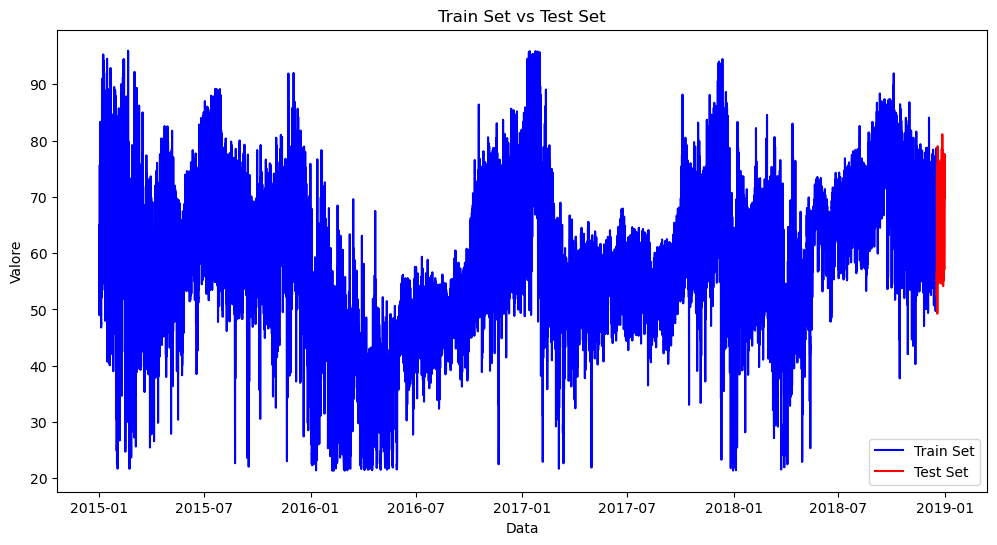

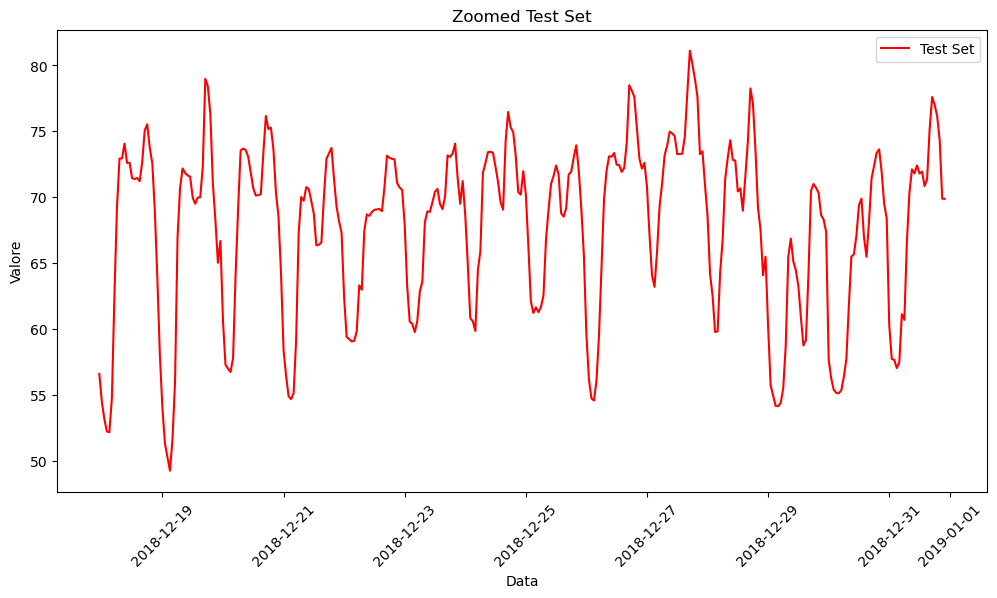

time
2015-01-01 00:00:00+00:00    64.92
2015-01-01 01:00:00+00:00    64.48
2015-01-01 02:00:00+00:00    59.32
2015-01-01 03:00:00+00:00    56.04
2015-01-01 04:00:00+00:00    53.63
                             ...  
2018-12-17 18:00:00+00:00    78.65
2018-12-17 19:00:00+00:00    78.69
2018-12-17 20:00:00+00:00    74.58
2018-12-17 21:00:00+00:00    69.78
2018-12-17 22:00:00+00:00    64.05
Name: price actual, Length: 34727, dtype: float64
time
2018-12-17 23:00:00+00:00    56.60
2018-12-18 00:00:00+00:00    54.50
2018-12-18 01:00:00+00:00    53.18
2018-12-18 02:00:00+00:00    52.23
2018-12-18 03:00:00+00:00    52.17
                             ...  
2018-12-31 18:00:00+00:00    77.02
2018-12-31 19:00:00+00:00    76.16
2018-12-31 20:00:00+00:00    74.30
2018-12-31 21:00:00+00:00    69.89
2018-12-31 22:00:00+00:00    69.88
Name: price actual, Length: 336, dtype: float64


In [128]:
test_size = -24*14

y_test=y[(test_size):]
y_train=y[:(test_size)]

plt.figure(figsize=(12, 6))

# Plot del train set
plt.plot(y_train.index, y_train, label='Train Set', color='blue')

# Plot del test set
plt.plot(y_test.index, y_test, label='Test Set', color='red')

# Aggiunta di titolo e etichette
plt.title('Train Set vs Test Set')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.legend()

# Visualizzazione del grafico
plt.show()


plt.figure(figsize=(12, 6))

# Plot del test set
plt.plot(y_test.index, y_test, label='Test Set', color='red')

# Aggiunta di titolo e etichette
plt.title('Zoomed Test Set')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.xticks(rotation=45)
plt.legend()

# Visualizzazione del grafico
plt.show()

print(y_train)

print(y_test)

# KNN Forecasting

KNN is an algorithm that is as simple as it is effective in machine learning. Also used in classification, it is based on obtaining the value calculated on the basis of an average (weighted or standard, depending on preference) of the value of the ‘nearest neighbours’ (hence the name). For a more detailed explaination: https://github.com/CarloSantam/KNN-from-scratch. 

MAPE without pca computed is: 5.65 %
MAE without pca computed is: 3.66
MAPE without pca computed is: 5.6 %
MAE without pca computed is: 3.67


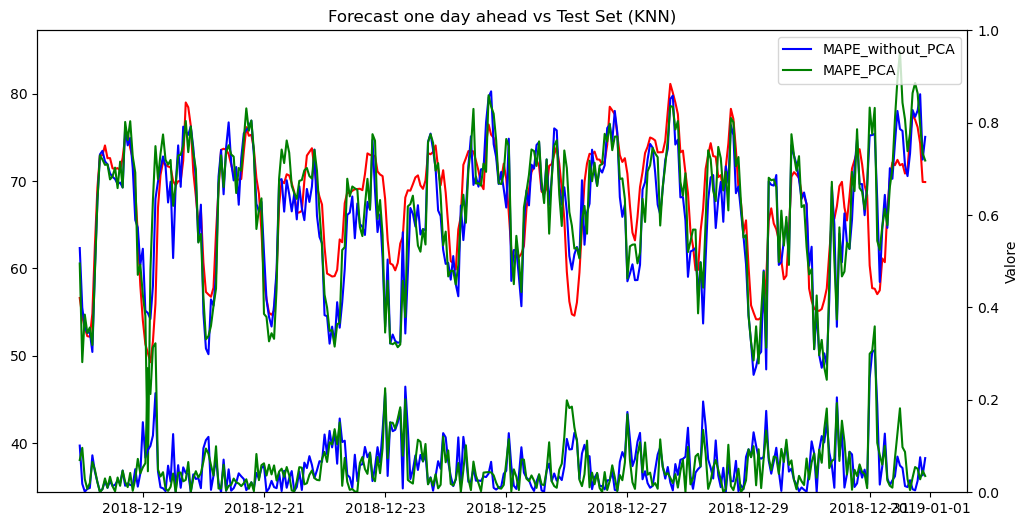

In [129]:
X_train = X_pca[:test_size]
X_test = X_pca[test_size:]


reg =KNeighborsRegressor(n_neighbors=5,weights='distance', algorithm='auto')

reg.fit(X_train, (y_train))

y_pred=reg.predict(X_test)

print(f"MAPE without pca computed is: {round(np.mean(np.abs(y_test-y_pred)/y_test)*100,2)} %")

print(f"MAE without pca computed is: {round(np.mean(np.abs(y_test-y_pred)),2)}")

X_train = X_stand[:test_size]
X_test = X_stand[test_size:]


reg =KNeighborsRegressor(n_neighbors=5,weights='distance', algorithm='auto')

reg.fit(X_train, (y_train))

y_pred_nopca=reg.predict(X_test)

print(f"MAPE without pca computed is: {round(np.mean(np.abs(y_test-y_pred_nopca)/y_test)*100,2)} %")

print(f"MAE without pca computed is: {round(np.mean(np.abs(y_test-y_pred_nopca)),2)}")


plt.figure(figsize=(12, 6))

plt.plot(y_test.index, y_test, label='Test Set', color='red')

plt.plot(y_test.index, (y_pred_nopca), label='Fcst without pca', color='blue')

plt.plot(y_test.index, (y_pred), label='Fcst with pca', color='green')


plt.twinx()
plt.plot(y_test.index,np.abs(y_test-y_pred_nopca)/y_test, label='MAPE_without_PCA', color='blue')

plt.plot(y_test.index, np.abs(y_test-y_pred)/y_test, label='MAPE_PCA', color='green')

plt.ylim(0, 1)


plt.xticks(rotation=45)


plt.legend(loc='best')


plt.xticks(rotation=90)

plt.title('Forecast one day ahead vs Test Set (KNN)')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.legend()

plt.show()


# XGBOOST Forecasting


Xgboost is a very popoular implementation of gradient boosting algorithm (https://github.com/CarloSantam/Gradient-Boosting-from-Scratch). Cool thing in xgboost is the very simple implementation and applicability in codes without difficulties. Furthermore, the high efficiency of the algorithm (accompanied by the use of decision trees as weak learners) allows features to be managed very easily.

In [130]:
X_train = X_pca[:test_size]
X_test = X_pca[test_size:]


reg = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=5000,
                       early_stopping_rounds=100,
                       objective='reg:squarederror',
                       max_depth=3,
                       eval_metric='rmse',
                       learning_rate=0.01)
reg.fit(X_train, (y_train),
        eval_set=[(X_train, (y_train)), (X_test, (y_test))],
        verbose=100)

y_pred=reg.predict(X_test)

[0]	validation_0-rmse:13.69992	validation_1-rmse:11.78226
[100]	validation_0-rmse:10.88613	validation_1-rmse:9.46952
[200]	validation_0-rmse:9.61050	validation_1-rmse:7.66984
[300]	validation_0-rmse:8.82405	validation_1-rmse:6.18452
[400]	validation_0-rmse:8.29156	validation_1-rmse:5.17774
[500]	validation_0-rmse:7.91170	validation_1-rmse:4.58195
[600]	validation_0-rmse:7.62761	validation_1-rmse:4.17031
[700]	validation_0-rmse:7.40299	validation_1-rmse:3.88411
[800]	validation_0-rmse:7.22102	validation_1-rmse:3.71379
[900]	validation_0-rmse:7.07449	validation_1-rmse:3.61155
[1000]	validation_0-rmse:6.95228	validation_1-rmse:3.54474
[1100]	validation_0-rmse:6.84735	validation_1-rmse:3.51707
[1200]	validation_0-rmse:6.75906	validation_1-rmse:3.50589
[1300]	validation_0-rmse:6.68072	validation_1-rmse:3.50576
[1343]	validation_0-rmse:6.65036	validation_1-rmse:3.50916


In [131]:
X_train = X_stand[:test_size]
X_test = X_stand[test_size:]

reg = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=5000,
                       early_stopping_rounds=100,
                       objective='reg:squarederror',
                       max_depth=3,
                       eval_metric='rmse',
                       learning_rate=0.01)
reg.fit(X_train, (y_train),
        eval_set=[(X_train, (y_train)), (X_test, (y_test))],
        verbose=100)

y_pred_nopca=reg.predict(X_test)


[0]	validation_0-rmse:13.65586	validation_1-rmse:11.72249
[100]	validation_0-rmse:8.43431	validation_1-rmse:6.21971
[200]	validation_0-rmse:6.96965	validation_1-rmse:4.61448
[300]	validation_0-rmse:6.37526	validation_1-rmse:4.13050
[400]	validation_0-rmse:6.05640	validation_1-rmse:3.81291
[500]	validation_0-rmse:5.84638	validation_1-rmse:3.61990
[600]	validation_0-rmse:5.70675	validation_1-rmse:3.50455
[700]	validation_0-rmse:5.59971	validation_1-rmse:3.45933
[800]	validation_0-rmse:5.51697	validation_1-rmse:3.41831
[900]	validation_0-rmse:5.45239	validation_1-rmse:3.39499
[1000]	validation_0-rmse:5.38963	validation_1-rmse:3.39215
[1100]	validation_0-rmse:5.33402	validation_1-rmse:3.42485
[1109]	validation_0-rmse:5.32973	validation_1-rmse:3.42394


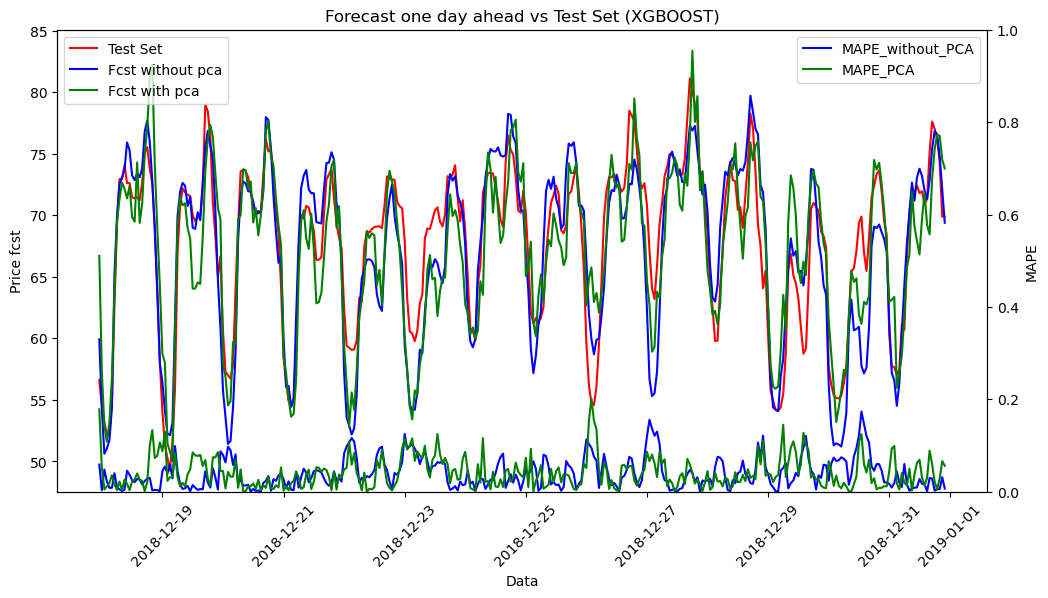

MAPE without pca computed is: 3.99 %
MAPE with pca computed is: 4.14 %
MAE with pca computed is: 2.64
MAE without pca computed is: 2.75


In [132]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.index, y_test, label='Test Set', color='red')

plt.plot(y_test.index, (y_pred_nopca), label='Fcst without pca', color='blue')

plt.plot(y_test.index, (y_pred), label='Fcst with pca', color='green')

plt.xticks(rotation=45)

plt.title('Forecast one day ahead vs Test Set (XGBOOST)')
plt.xlabel('Data')
plt.ylabel('Price fcst')
plt.legend(loc='upper left')

plt.twinx()
plt.plot(y_test.index,np.abs(y_test-y_pred_nopca)/y_test, label='MAPE_without_PCA', color='blue')

plt.plot(y_test.index, np.abs(y_test-y_pred)/y_test, label='MAPE_PCA', color='green')

plt.ylabel('MAPE')

plt.ylim(0, 1)


plt.xticks(rotation=45)


plt.legend(loc='best')

plt.show()

print(f"MAPE without pca computed is: {round(np.mean(np.abs(y_test-y_pred_nopca)/y_test)*100,2)} %")

print(f"MAPE with pca computed is: {round(np.mean(np.abs(y_test-y_pred)/y_test)*100,2)} %")

print(f"MAE with pca computed is: {round(np.mean(np.abs(y_test-y_pred_nopca)),2)}")

print(f"MAE without pca computed is: {round(np.mean(np.abs(y_test-y_pred)),2)}")



# Some Deep NN

In [133]:
def sequence_creation(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)


In [134]:
train_end_idx = X.shape[0]-np.abs(test_size)
test_end_idx = X.shape[0]

print(train_end_idx)

34727


In [135]:
X_pca_array=np.array(X_pca)

y_array=np.array(y).reshape(-1,1)

print(f"Feature's set has the following dimensions: {X_pca_array.shape}")

print(f"Target's set has the following dimensions: {y_array.shape}")


Feature's set has the following dimensions: (35063, 24)
Target's set has the following dimensions: (35063, 1)


In [136]:
dataset_norm = np.concatenate((X_pca_array, y_array), axis=1)

past_history = 24
future_target = 0

In [137]:
X_train, y_train = sequence_creation(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [138]:
print(X_train.shape)
print(y_train.shape)

(34703, 24, 25)
(34703,)


In [139]:
X_test, y_test = sequence_creation(dataset_norm, dataset_norm[:, -1],
                                   train_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [140]:
print(X_test.shape)
print(y_test.shape)

(312, 24, 25)
(312,)


In [141]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [142]:
from tensorflow.keras.optimizers import Adam,SGD
tf.keras.backend.clear_session()



model = Sequential()
model.add(Conv1D(80, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,loss='mse')

model.fit(X_train,y_train,epochs=20,validation_data=(X_test, y_test), verbose=1,callbacks=[early_stopping])

y_pred=model.predict(X_test)

Epoch 1/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 72.1744 - val_loss: 15.8909
Epoch 2/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 15.1410 - val_loss: 7.7128
Epoch 3/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 13.6471 - val_loss: 7.6043
Epoch 4/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 12.3877 - val_loss: 7.9452
Epoch 5/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 12.0490 - val_loss: 7.8151
Epoch 6/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 11.5988 - val_loss: 7.0985
Epoch 7/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 11.1362 - val_loss: 7.9687
Epoch 8/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 10.6129 - val_loss: 10.8194
Epoch 9/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 10.6513 - val_loss: 7.8961
Epoch 10/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 10.3083 - val_loss: 9.4052
Epoch 11/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 10.0139 - val_loss: 7.9416
Epoch 12/20
1085/

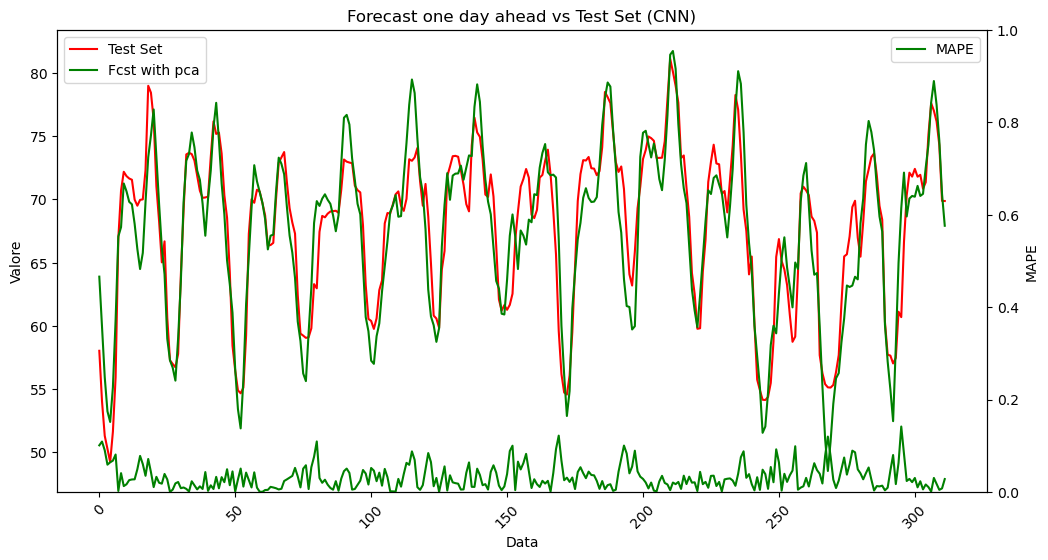

MAPE computed is: 3.22 %
MAE computed is: 2.14


In [143]:
plt.figure(figsize=(12, 6))

plt.plot(y_test, label='Test Set', color='red')

plt.plot((y_pred), label='Fcst with pca', color='green')

plt.xticks(rotation=45)

plt.title('Forecast one day ahead vs Test Set (CNN)')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.legend(loc='upper left')


plt.twinx()

plt.plot(np.abs(y_test-y_pred.reshape(-1))/y_test, label='MAPE', color='green')

plt.ylabel('MAPE')

plt.ylim(0, 1)


plt.legend(loc='best')


plt.show()


print(f"MAPE computed is: {round(np.mean(np.abs(y_test-y_pred.reshape(-1))/y_test)*100,2)} %")

print(f"MAE computed is: {round(np.mean(np.abs(y_test-y_pred.reshape(-1))),2)}")


In [144]:
model = Sequential()
model.add(LSTM(50, input_shape=input_shape))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Addestramento del modello

model.fit(X_train,y_train,epochs=20,validation_data=(X_test, y_test), verbose=1,callbacks=[early_stopping])

y_pred_lstm=model.predict(X_test)


Epoch 1/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 1987.2974 - val_loss: 436.9308
Epoch 2/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 170.4547 - val_loss: 47.1247
Epoch 3/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 35.0227 - val_loss: 7.4882
Epoch 4/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 14.7202 - val_loss: 3.7945
Epoch 5/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 9.4258 - val_loss: 3.7933
Epoch 6/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 7.7491 - val_loss: 3.6430
Epoch 7/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 6.6199 - val_loss: 3.5769
Epoch 8/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 6.1553 - val_loss: 4.0190
Epoch 9/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 5.9055 - val_loss: 3.2468
Epoch 10/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 5.6509 - val_loss: 5.1143
Epoch 11/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 5.5461 - val_loss: 2.9118
Epoch 12/20
1085/1

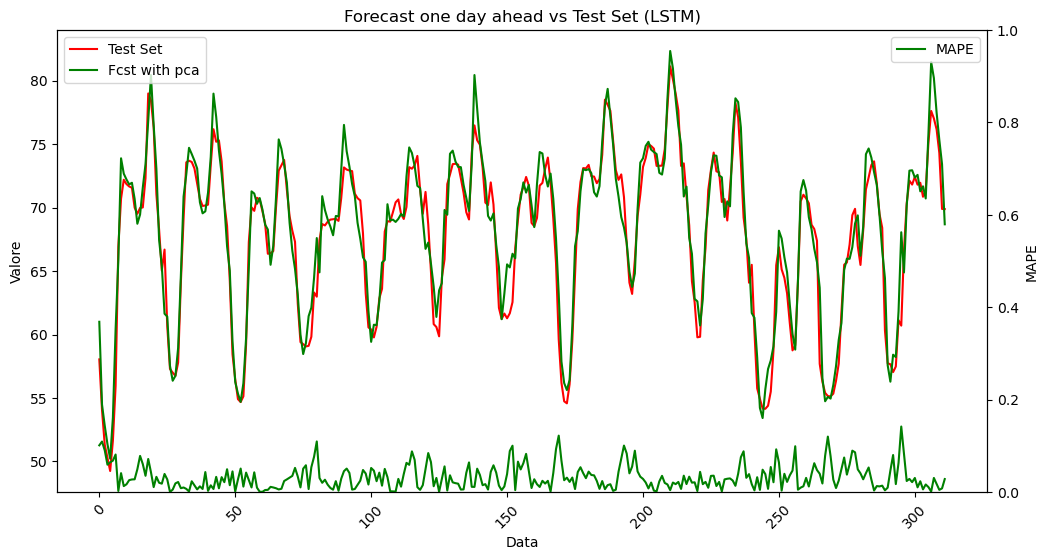

MAPE computed is: 1.93 %
MAE computed is: 1.28


In [145]:
plt.figure(figsize=(12, 6))

plt.plot(y_test, label='Test Set', color='red')

plt.plot((y_pred_lstm.reshape(-1)), label='Fcst with pca', color='green')

plt.xticks(rotation=45)

plt.title('Forecast one day ahead vs Test Set (LSTM)')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.legend(loc='upper left')


plt.twinx()

plt.plot(np.abs(y_test-y_pred.reshape(-1))/y_test, label='MAPE', color='green')

plt.ylabel('MAPE')

plt.ylim(0, 1)


plt.legend(loc='best')


plt.show()


print(f"MAPE computed is: {round(np.mean(np.abs(y_test-y_pred_lstm.reshape(-1))/y_test)*100,2)} %")

print(f"MAE computed is: {round(np.mean(np.abs(y_test-y_pred_lstm.reshape(-1))),2)}")


